In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

In [677]:
PATH = r'C:\Users\Wyatt\wyatt37\data\energy'

In [678]:
train_col = ['num', 'date_time', 'target', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']
test_col = ['num', 'date_time', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']

In [679]:
train = pd.read_csv(PATH + '\\train.csv', encoding='cp949', names=train_col, header=0)
test = pd.read_csv(PATH + '\\test.csv', encoding='cp949', names=test_col, header=0)
sub = pd.read_csv(PATH + '\\sample_submission.csv', encoding='cp949')

In [680]:
def make_time(train):
    train['datetime'] = pd.to_datetime(train.date_time)
    
    train['month'] = train.datetime.dt.month                    # 월(숫자)
    train['day'] = train.datetime.dt.day                        # 일(숫자)
    train['hour'] = train.datetime.dt.hour                      # 시(숫자)
    train['weekday'] = train.datetime.dt.weekday                # 시(숫자)
    train['dayofyear'] = train.datetime.dt.dayofyear            # 연 기준 몇일째(숫자)
    train['weekofyear'] = train.datetime.dt.isocalendar().week  # 연 기준 몇주째(숫자) (=week)
    
    # 2차 time / 지지
    train['month_start'] = train.datetime.dt.is_month_start
    train['month_end'] = train.datetime.dt.is_month_end
    
    # 여기까지
    
    train.drop(['date_time', 'datetime'], axis=1, inplace=True)
    
    train.weekofyear = train.weekofyear.astype(int)
    
    return train

In [681]:
train = make_time(train)
test = make_time(test)

test의 rain 값을 중간값으로 채워줄 것이다.

In [682]:
# # 앞 뒤 3시간의 예보의 중간값으로 채워줍니다.
# for i in range(3, len(test), 6):
#     try:
#         test.loc[i, 'rain'] = (test.rain[i+3] + test.rain[i-3])/2
#     except:
#         test.loc[i, 'rain'] = 0

In [683]:
# cooler와 solar를 넣어주겠습니다.
for i in range(1, 61):
    test.loc[test.num == i, 'cooler'] = train.loc[train.num == i, 'cooler'].mean()
    test.loc[test.num == i, 'solar'] = train.loc[train.num == i, 'solar'].mean()

In [684]:
test[['temp', 'wind', 'humid', 'rain', 'sunny']] = test[['temp', 'wind', 'humid', 'rain', 'sunny']].interpolate(method='values').round(1)

## EDA_2

In [589]:
train

num    target  temp  wind  humid  rain  sunny  cooler  solar  month  \
0         1  8179.056  17.6   2.5   92.0   0.8    0.0     0.0    0.0      6   
1         1  8135.640  17.7   2.9   91.0   0.3    0.0     0.0    0.0      6   
2         1  8107.128  17.5   3.2   91.0   0.0    0.0     0.0    0.0      6   
3         1  8048.808  17.1   3.2   91.0   0.0    0.0     0.0    0.0      6   
4         1  8043.624  17.0   3.3   92.0   0.0    0.0     0.0    0.0      6   
...     ...       ...   ...   ...    ...   ...    ...     ...    ...    ...   
122395   60  4114.368  27.8   2.3   68.0   0.0    0.7     1.0    1.0      8   
122396   60  3975.696  27.3   1.2   71.0   0.0    0.0     1.0    1.0      8   
122397   60  3572.208  27.3   1.8   71.0   0.0    0.0     1.0    1.0      8   
122398   60  3299.184  27.1   1.8   74.0   0.0    0.0     1.0    1.0      8   
122399   60  3204.576  27.1   2.6   75.0   0.0    0.0     1.0    1.0      8   

        day  hour  weekday  dayofyear  weekofyear  month_start  month_end  
0         1     0        0        153          23         True      False  
1         1     1        0        153          23         True      False  
2         1     2        0        153          23         True      False  
3         1     3        0        153          23         True      False  
4         1     4        0        153          23         True      False  
...     ...   ...      ...        ...         ...          ...        ...  
122395   24    19        0        237          35        False      False  
122396   24    20        0        237          35        False      False  
122397   24    21        0        237          35        False      False  
122398   24    22        0        237          35        False      False  
122399   24    23        0        237          35        False      False  

[122400 rows x 17 columns]

In [16]:
train[['temp', 'wind', 'humid', 'rain', 'sunny']].describe().T

count       mean        std   min   25%   50%   75%    max
temp   122400.0  24.251713   3.407902  11.1  21.8  24.2  26.5   36.3
wind   122400.0   2.151641   1.514475   0.0   1.1   1.9   2.9   20.1
humid  122400.0  80.169848  15.525862  19.0  70.0  84.0  93.0  100.0
rain   122400.0   0.514989   2.624505   0.0   0.0   0.0   0.0   81.5
sunny  122400.0   0.213533   0.370517   0.0   0.0   0.0   0.3    1.0

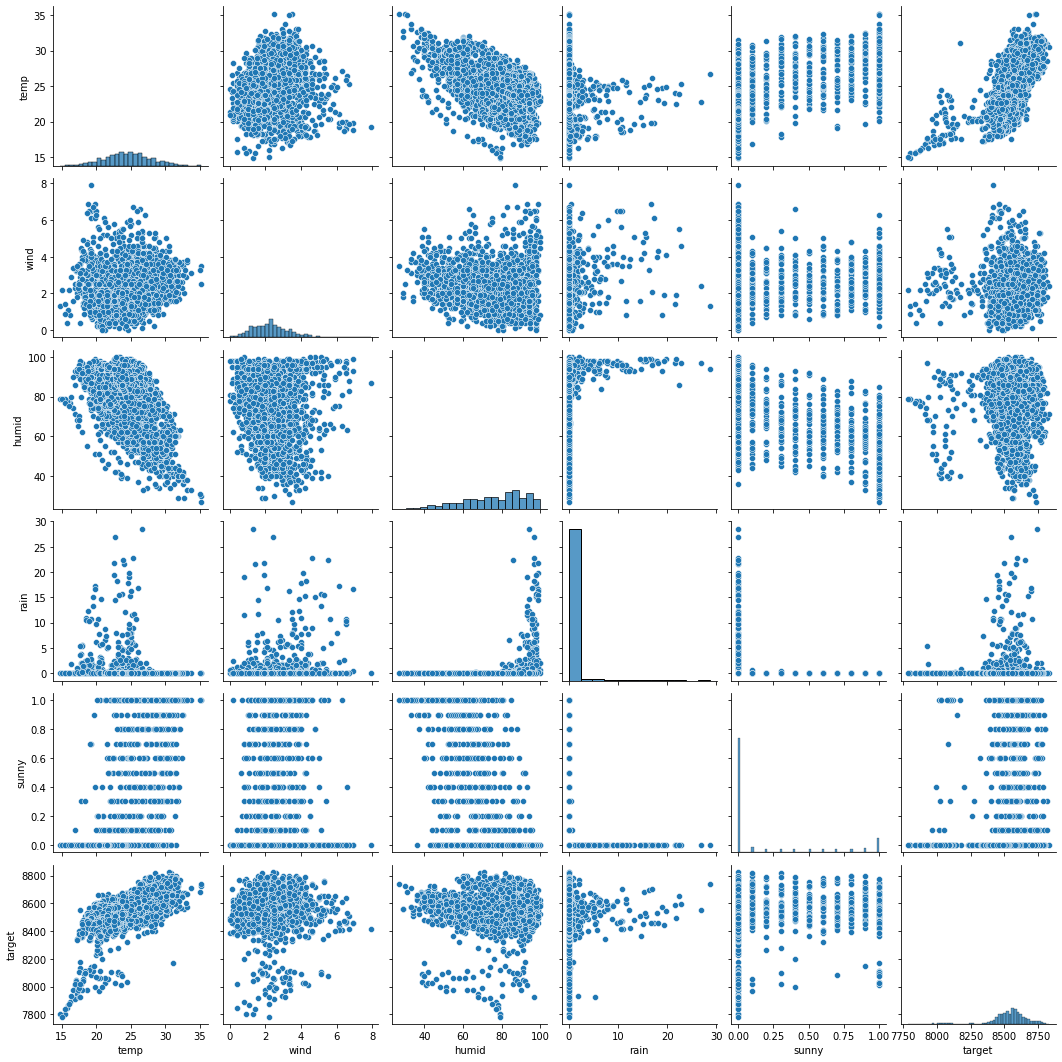

In [22]:
sns.pairplot(train.loc[train.num == 1, ['temp', 'wind', 'humid', 'rain', 'sunny', 'target']])

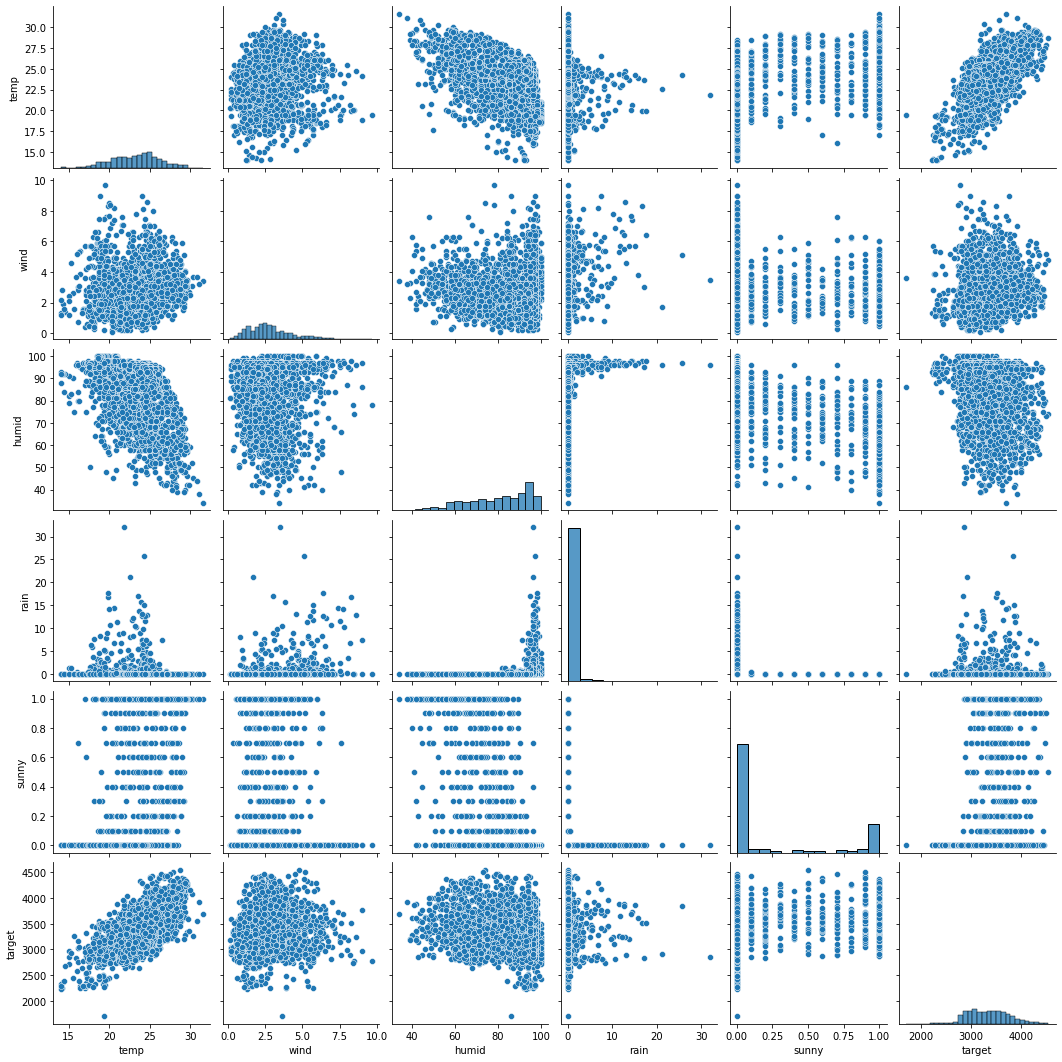

In [23]:
sns.pairplot(train.loc[train.num == 60, ['temp', 'wind', 'humid', 'rain', 'sunny', 'target']])

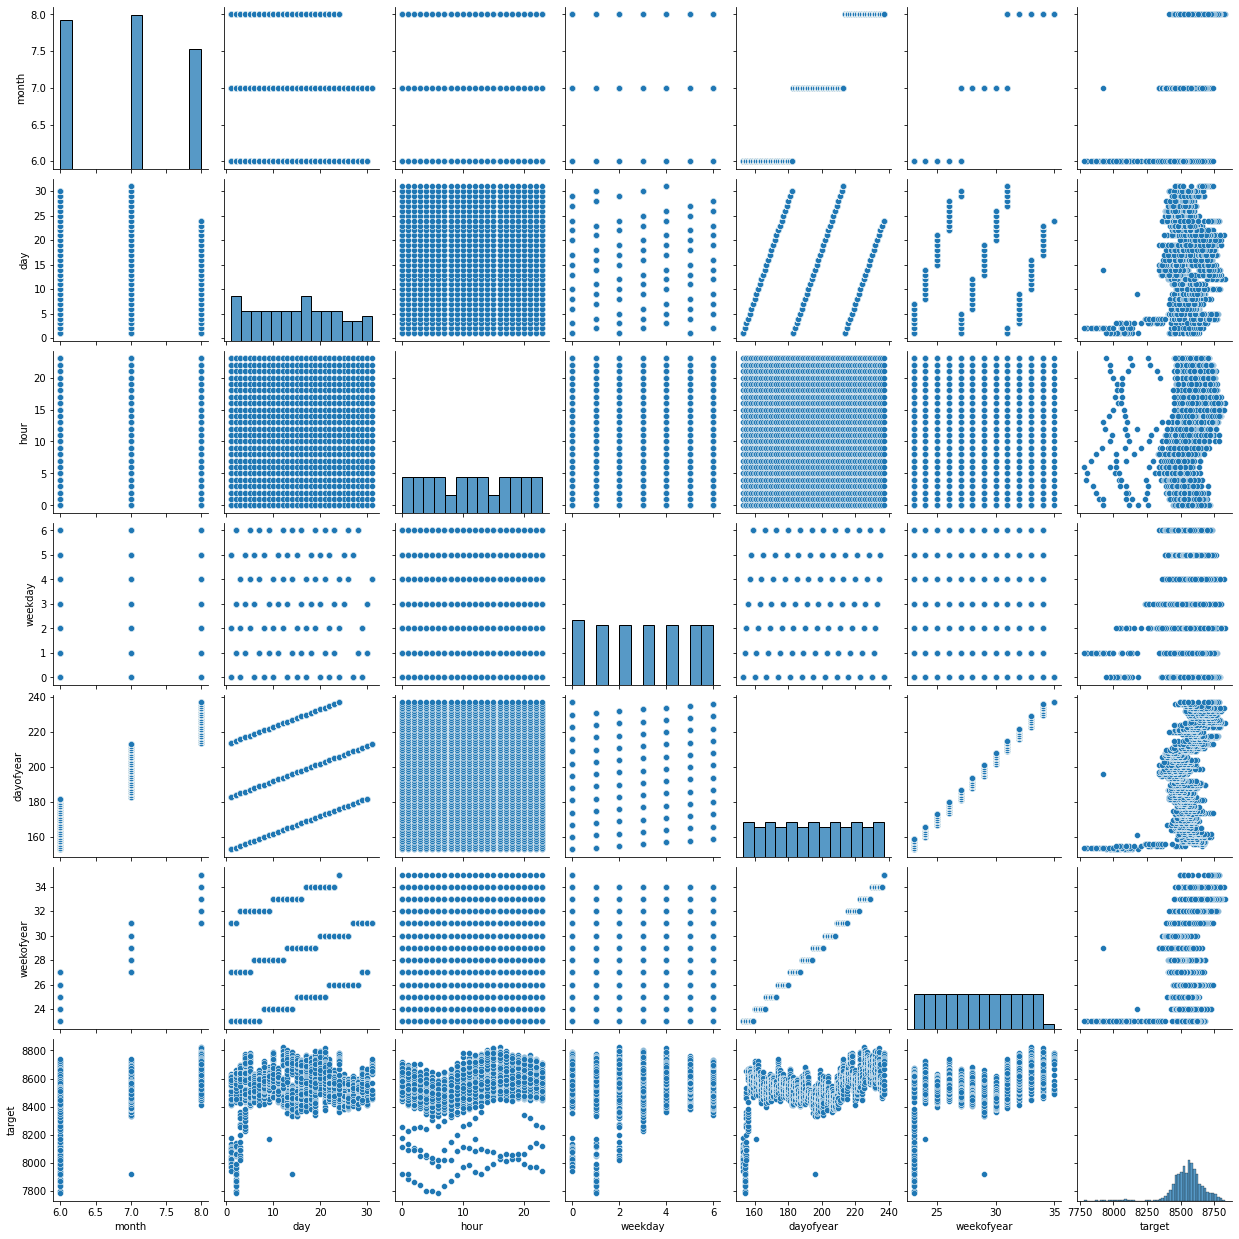

In [24]:
sns.pairplot(train.loc[train.num == 1, ['month', 'day', 'hour', 'weekday', 'dayofyear', 'weekofyear', 'target']])

### 빌딩별 모델 X 채워진 데이터로 예측하기(랜포)

In [18]:
for i in range(1, 61):
    # 빌딩별로 train_x을 만듭니다.
    globals()['train_building_{}'.format(i)] = train.loc[train.num == i,
                                                         ~train.columns.isin(['target', 'num', 'cooler', 'solar'])]
    
    # 빌딩별로 train_y 를 만듭니다.
    globals()['train_building_{}_y'.format(i)] = train.loc[train.num == i, 'target']
    
    # 빌딩별로 test_x 를 만듭니다.
    globals()['test_building_{}'.format(i)] = test.loc[test.num == i,
                                                       ~test.columns.isin(['num', 'cooler', 'solar'])]

In [19]:
train_building_60.shape, train_building_60_y.shape, test_building_60.shape

((2040, 13), (2040,), (168, 13))

In [90]:
preds = []
fe = []
oob_scores = []
for i in tqdm(range(1, 61)):
    rf = RandomForestRegressor(random_state=42, oob_score=True)
    rf.fit(globals()['train_building_{}'.format(i)], globals()['train_building_{}_y'.format(i)])
    pred = rf.predict(globals()['test_building_{}'.format(i)])
    preds.append(pred.tolist())
    fe.append(rf.feature_importances_)
    oob_scores.append(rf.oob_score_)
    
print(np.std(oob_scores), np.mean(oob_scores))

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:37<00:00,  1.59it/s]


In [22]:
preds = sum(preds, [])

In [23]:
sub.answer = preds

In [26]:
sub.to_csv('submission/210607_rf-vanila_each-buildingsXfilled-hours_dropcols+monthstartend.csv', index=False)
sub

num_date_time      answer
0       1 2020-08-25 00  8673.35688
1       1 2020-08-25 01  8669.26800
2       1 2020-08-25 02  8666.08632
3       1 2020-08-25 03  8658.16128
4       1 2020-08-25 04  8654.22792
...                 ...         ...
10075  60 2020-08-31 19  4057.02000
10076  60 2020-08-31 20  4000.44960
10077  60 2020-08-31 21  3825.41616
10078  60 2020-08-31 22  3522.54096
10079  60 2020-08-31 23  3385.73520

[10080 rows x 2 columns]

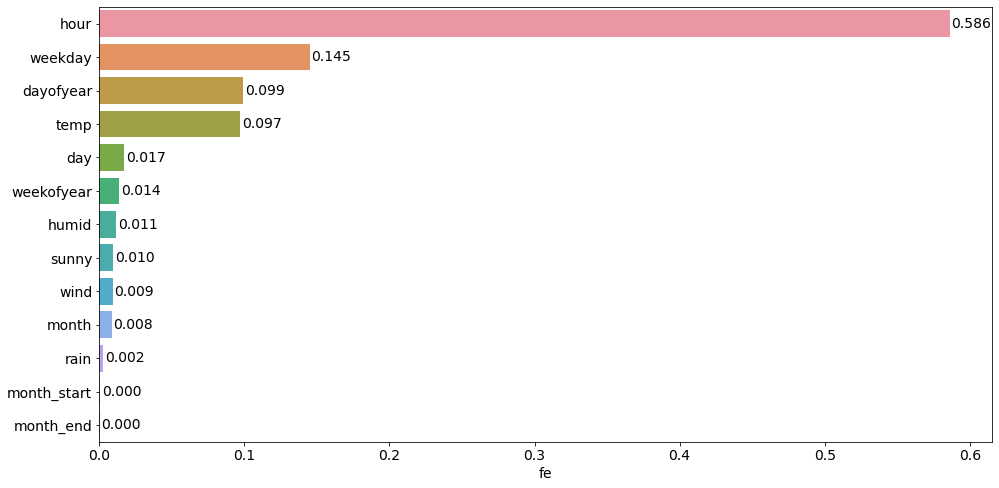

In [91]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fe, axis=0),
                      index=train_building_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(16, 8))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

In [92]:
np.std(oob_scores), np.mean(oob_scores)

(0.05756924908729318, 0.9512424957929433)

### Discomfort Index

In [44]:
from IPython.display import Image
Image(url='https://www.kma.go.kr/images/HELP/basic_new/modify_03.gif',
      width=500
     )

In [57]:
def di(train):
    train['DI'] = (1.8*train.temp - 0.55*(1-(train.humid/100)) * (1.8*train.temp - 26) + 32).round(2)
    
    return train

In [59]:
train = di(train)
test = di(test)

In [83]:
for i in range(1, 61):
    # 빌딩별로 train_x을 만듭니다.
    globals()['train_building_{}'.format(i)] = train.loc[train.num == i,
                                                         ~train.columns.isin(['target', 'num', 'cooler', 'solar'])]
    
    # 빌딩별로 train_y 를 만듭니다.
    globals()['train_building_{}_y'.format(i)] = train.loc[train.num == i, 'target']
    
    # 빌딩별로 test_x 를 만듭니다.
    globals()['test_building_{}'.format(i)] = test.loc[test.num == i,
                                                       ~test.columns.isin(['num', 'cooler', 'solar'])]

In [84]:
train_building_60.shape, train_building_60_y.shape, test_building_60.shape

((2040, 11), (2040,), (168, 11))

In [85]:
preds = []
fe = []
for i in tqdm(range(1, 61)):
    rf = RandomForestRegressor(random_state=42)
    rf.fit(globals()['train_building_{}'.format(i)], globals()['train_building_{}_y'.format(i)])
    pred = rf.predict(globals()['test_building_{}'.format(i)])
    preds.append(pred.tolist())
    fe.append(rf.feature_importances_)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:33<00:00,  1.77it/s]


In [63]:
preds = sum(preds, [])

In [64]:
sub.answer = preds

In [65]:
sub.to_csv('submission/210606_rf-vanila_each-buildingsXfilled-hours_dropcols+di.csv', index=False)
sub

num_date_time      answer
0       1 2020-08-25 00  8674.65936
1       1 2020-08-25 01  8673.22080
2       1 2020-08-25 02  8673.65496
3       1 2020-08-25 03  8663.15736
4       1 2020-08-25 04  8631.49608
...                 ...         ...
10075  60 2020-08-31 19  4139.08272
10076  60 2020-08-31 20  4012.20864
10077  60 2020-08-31 21  3800.21760
10078  60 2020-08-31 22  3549.73536
10079  60 2020-08-31 23  3419.52192

[10080 rows x 2 columns]

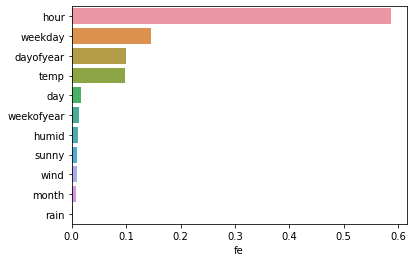

In [105]:
fe_avg = pd.DataFrame(np.mean(fe, axis=0),
                      index=train_building_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)
sns.barplot(fe_avg.fe, y=fe_avg.index)
plt.show()

### Clustering

In [590]:
from sklearn.cluster import KMeans

In [591]:
weekday_mean = (
    train.groupby(['num', 'weekday'])['target'].mean()
    .reset_index()
    .pivot('num', 'weekday', 'target')
    .reset_index()
)

In [592]:
weekday_std = (
    train.groupby(['num', 'weekday'])['target'].std()
    .reset_index()
    .pivot('num', 'weekday', 'target')
    .reset_index()
    .drop('num', axis=1)
)

In [593]:
hour_mean = (
    train.groupby(['num', 'hour'])['target'].mean()
    .reset_index()
    .pivot('num', 'hour', 'target')
    .reset_index()
    .drop('num', axis=1)
)

In [594]:
hour_std = (
    train.groupby(['num', 'hour'])['target'].std()
    .reset_index()
    .pivot('num', 'hour', 'target')
    .reset_index()
    .drop('num', axis=1)
)

In [595]:
cl_df = pd.concat([weekday_mean, hour_mean, weekday_std, hour_std], axis=1)

In [596]:
columns = (
    ['num']
    + ['day_mean_' + str(i) for i in range(7)]
    + ['hour_mean_' + str(i) for i in range(24)]
    + ['day_std_' + str(i) for i in range(7)]
    + ['hour_std_' + str(i) for i in range(24)]
)

In [597]:
cl_df.columns = columns
cl_df

num   day_mean_0    day_mean_1    day_mean_2    day_mean_3   day_mean_4  \
0     1  8541.545538   8507.432250   8551.757250   8561.101500  8570.308500   
1     2  1373.904346   1383.035625   1389.466125   1402.357500  1390.788000   
2     3  3371.143240   3371.748507   3398.873622   3406.395846  3402.517822   
3     4   684.863829    678.183456    727.799464    794.561580   825.467101   
4     5  2720.551846   2703.939000   2698.137000   2685.795000  2838.414000   
5     6  1360.713462   1387.191562   1397.536875   1420.080000  1363.089375   
6     7  1713.551068   1739.770085   1742.421445   1754.745388  1725.808552   
7     8  9802.109005  10089.995499  10092.764069  10174.166041  9950.387163   
8     9  1251.729692   1255.232942   1261.113000   1254.965625  1266.738375   
9    10  1280.171886   1443.655199   1432.642765   1435.489290  1494.744877   
10   11  2343.378462   2302.836000   2321.251500   2320.753500  2379.034500   
11   12  1710.526154   1666.771500   1688.803980   1712.085167  1758.331500   
12   13  1135.676596   1157.240250   1149.654938   1166.348250  1180.881563   
13   14  1873.493481   1891.787625   1903.118250   1913.319187  1881.988125   
14   15  2291.880523   2252.779649   2316.704729   2319.136258  2281.205177   
15   16  1693.252038   1708.066125   1704.098250   1706.437125  1697.551875   
16   17  1159.563462   1179.772500   1178.631562   1194.841875  1175.045625   
17   18  2034.867504   2154.119555   2112.491477   2136.631088  2095.856177   
18   19   842.277462    808.801219    824.553000    828.214875   809.260313   
19   20  1484.566269   1428.607635   1449.084885   1445.248500  1426.512563   
20   21  1645.105846   1644.725250   1668.723750   1674.870750  1659.836250   
21   22  1253.109462   1278.039375   1284.174000   1275.445125  1259.158500   
22   23  1937.799133   1991.353333   2032.650183   2083.105124  1967.603269   
23   24  3116.261077   3164.562000   3226.495500   3296.289000  3223.765500   
24   25  1615.129615   1656.689625   1650.543750   1672.389000  1640.954250   
25   26  3152.416016   3229.327721   3173.488412   3139.548188  3073.390197   
26   27   722.526923    759.390937    752.247187    746.601562   703.373437   
27   28  2245.473000   2180.876625   2169.800625   2239.987125  2293.420875   
28   29   865.627788    834.465044    850.412250    844.729656   837.820688   
29   30  5747.463491   5678.597326   5609.128866   5714.021206  5757.054623   
30   31  5991.975692   5973.949500   5993.125500   5984.323500  5997.039000   
31   32  2407.574077   2400.441750   2405.673750   2411.278500  2407.997250   
32   33  2600.550692   2610.896250   2617.141500   2610.946500  2605.066500   
33   34   766.699550    982.900125    928.583643    978.297022   983.646000   
34   35  1442.532488   1477.416000   1495.468500   1514.275500  1492.161000   
35   36  1093.037538   1083.224583   1084.925250   1080.591750  1095.738000   
36   37  2111.237758   2183.634129   2157.572116   2184.115140  2122.472855   
37   38  7793.124231   7733.801250   7832.273750   8045.528750  7968.353750   
38   39  1888.447967   1901.671139   1896.327236   1919.285924  1925.173539   
39   40  2443.914527   2560.682999   2584.073458   2588.378873  2670.319929   
40   41  1251.688384   1237.316625   1236.526875   1254.232687  1247.123250   
41   42  3177.167495   3476.169649   3613.231539   3631.689187  3775.192890   
42   43  1880.671154   1962.665250   1884.576000   1994.283750  1886.127000   
43   44  2558.942654   2572.940250   2586.008250   2587.377375  2567.709000   
44   45  1445.096265   1421.071390   1435.279973   1448.269016  1440.250683   
45   46  2071.548000   2091.991500   2089.164000   2097.592500  2066.971500   
46   47  2308.763036   2349.851275   2361.956118   2360.777559  2328.679333   
47   48  1289.913453   1399.177063   1427.873344   1457.632375  1383.028375   
48   49  1168.877934   1135.598672   1153.108878   1155.974338  1139.350257   
49   50  1073.311615   1035.588000   1057.539750   106

In [598]:
for i in range(len(cl_df)):
    cl_df.iloc[i, 1:8] = (cl_df.iloc[i, 1:8] - cl_df.iloc[i, 1:8].mean()) / cl_df.iloc[i, 1:8].std()
    cl_df.iloc[i, 8:32] = (cl_df.iloc[i, 8:32] - cl_df.iloc[i, 8:32].mean()) / cl_df.iloc[i, 8:32].std()
    cl_df.iloc[i, 32:39] = (cl_df.iloc[i, 32:39] - cl_df.iloc[i, 32:39].mean()) / cl_df.iloc[i, 32:39].std()
    cl_df.iloc[i, 39:] = (cl_df.iloc[i, 39:] - cl_df.iloc[i, 39:].mean()) / cl_df.iloc[i, 39:].std()

In [599]:
model = KMeans(n_clusters = 4, random_state = 42)
pred = model.fit_predict(cl_df.iloc[:, 1:])

In [600]:
cl_df['km_cluster'] = pred

In [601]:
train_cl = pd.merge(train, cl_df[['num', 'km_cluster']], how='left', on='num')

In [602]:
train_cl

num    target  temp  wind  humid  rain  sunny  cooler  solar  month  \
0         1  8179.056  17.6   2.5   92.0   0.8    0.0     0.0    0.0      6   
1         1  8135.640  17.7   2.9   91.0   0.3    0.0     0.0    0.0      6   
2         1  8107.128  17.5   3.2   91.0   0.0    0.0     0.0    0.0      6   
3         1  8048.808  17.1   3.2   91.0   0.0    0.0     0.0    0.0      6   
4         1  8043.624  17.0   3.3   92.0   0.0    0.0     0.0    0.0      6   
...     ...       ...   ...   ...    ...   ...    ...     ...    ...    ...   
122395   60  4114.368  27.8   2.3   68.0   0.0    0.7     1.0    1.0      8   
122396   60  3975.696  27.3   1.2   71.0   0.0    0.0     1.0    1.0      8   
122397   60  3572.208  27.3   1.8   71.0   0.0    0.0     1.0    1.0      8   
122398   60  3299.184  27.1   1.8   74.0   0.0    0.0     1.0    1.0      8   
122399   60  3204.576  27.1   2.6   75.0   0.0    0.0     1.0    1.0      8   

        day  hour  weekday  dayofyear  weekofyear  month_start  month_end  \
0         1     0        0        153          23         True      False   
1         1     1        0        153          23         True      False   
2         1     2        0        153          23         True      False   
3         1     3        0        153          23         True      False   
4         1     4        0        153          23         True      False   
...     ...   ...      ...        ...         ...          ...        ...   
122395   24    19        0        237          35        False      False   
122396   24    20        0        237          35        False      False   
122397   24    21        0        237          35        False      False   
122398   24    22        0        237          35        False      False   
122399   24    23        0        237          35        False      False   

        km_cluster  
0                2  
1                2  
2                2  
3                2  
4                2  
...            ...  
122395           3  
122396           3  
122397           3  
122398           3  
122399           3  

[122400 rows x 18 columns]

In [603]:
test_cl = test.copy()

In [604]:
# cooler와 solar를 넣어주겠습니다.
for i in range(1, 61):
    test_cl.loc[test_cl.num == i, 'km_cluster'] = (
        train_cl.loc[train_cl.num == i, 'km_cluster'].max()
    )

In [605]:
test_cl

num  temp  wind  humid  rain  sunny  cooler  solar  month  day  hour  \
0        1  27.8   1.5   74.0   0.0    0.0     0.0    0.0      8   25     0   
1        1  27.6   1.4   75.3   0.0    0.0     0.0    0.0      8   25     1   
2        1  27.5   1.2   76.7   0.0    0.0     0.0    0.0      8   25     2   
3        1  27.3   1.1   78.0   0.0    0.0     0.0    0.0      8   25     3   
4        1  26.9   1.2   79.7   0.0    0.0     0.0    0.0      8   25     4   
...    ...   ...   ...    ...   ...    ...     ...    ...    ...  ...   ...   
10075   60  28.6   3.6   66.0   0.0    0.5     1.0    1.0      8   31    19   
10076   60  28.3   3.8   67.0   0.0    0.3     1.0    1.0      8   31    20   
10077   60  27.9   4.1   68.0   0.0    0.0     1.0    1.0      8   31    21   
10078   60  27.9   4.1   68.0   0.0    0.0     1.0    1.0      8   31    22   
10079   60  27.9   4.1   68.0   0.0    0.0     1.0    1.0      8   31    23   

       weekday  dayofyear  weekofyear  month_start  month_end  km_cluster  
0            1        238          35        False      False         2.0  
1            1        238          35        False      False         2.0  
2            1        238          35        False      False         2.0  
3            1        238          35        False      False         2.0  
4            1        238          35        False      False         2.0  
...        ...        ...         ...          ...        ...         ...  
10075        0        244          36        False       True         3.0  
10076        0        244          36        False       True         3.0  
10077        0        244          36        False       True         3.0  
10078        0        244          36        False       True         3.0  
10079        0        244          36        False       True         3.0  

[10080 rows x 17 columns]

In [606]:
def di(train):
    train['DI'] = (1.8*train.temp - 0.55*(1-(train.humid/100)) * (1.8*train.temp - 26) + 32).round(2)
    
    return train

In [607]:
train_cl = di(train_cl)
test_cl = di(test_cl)

#### train, test 찢기

In [228]:
train_cl_0 = train_cl.loc[train_cl.km_cluster == 0,
                          ~train_cl.columns.isin(['target', 'km_cluster'])].reset_index(drop=True)
train_cl_1 = train_cl.loc[train_cl.km_cluster == 1,
                          ~train_cl.columns.isin(['target', 'km_cluster'])].reset_index(drop=True)
train_cl_2 = train_cl.loc[train_cl.km_cluster == 2,
                          ~train_cl.columns.isin(['target', 'km_cluster'])].reset_index(drop=True)
train_cl_3 = train_cl.loc[train_cl.km_cluster == 3,
                          ~train_cl.columns.isin(['target', 'km_cluster'])].reset_index(drop=True)

In [229]:
train_cl_0.shape, train_cl_1.shape, train_cl_2.shape, train_cl_3.shape

((73440, 17), (20400, 17), (8160, 17), (20400, 17))

In [230]:
train_cl_0_y = train_cl.loc[train_cl.km_cluster == 0, 'target'].reset_index(drop=True)
train_cl_1_y = train_cl.loc[train_cl.km_cluster == 1, 'target'].reset_index(drop=True)
train_cl_2_y = train_cl.loc[train_cl.km_cluster == 2, 'target'].reset_index(drop=True)
train_cl_3_y = train_cl.loc[train_cl.km_cluster == 3, 'target'].reset_index(drop=True)

In [231]:
train_cl_0_y.shape, train_cl_1_y.shape, train_cl_2_y.shape, train_cl_3_y.shape

((73440,), (20400,), (8160,), (20400,))

In [232]:
test_cl_0 = test_cl.loc[test_cl.km_cluster == 0, ~test_cl.columns.isin(['km_cluster'])]
test_cl_1 = test_cl.loc[test_cl.km_cluster == 1, ~test_cl.columns.isin(['km_cluster'])]
test_cl_2 = test_cl.loc[test_cl.km_cluster == 2, ~test_cl.columns.isin(['km_cluster'])]
test_cl_3 = test_cl.loc[test_cl.km_cluster == 3, ~test_cl.columns.isin(['km_cluster'])]

In [233]:
test_cl_0.shape, test_cl_1.shape, test_cl_2.shape, test_cl_3.shape

((6048, 17), (1680, 17), (672, 17), (1680, 17))

In [234]:
train_x_sets = [train_cl_0, train_cl_1, train_cl_2, train_cl_3]
train_y_sets = [train_cl_0_y, train_cl_1_y, train_cl_2_y, train_cl_3_y]
test_x_sets = [test_cl_0, test_cl_1, test_cl_2, test_cl_3]

In [137]:
preds = []
fe = []
for x, y, t in tqdm(zip(train_x_sets, train_y_sets, test_x_sets)):
    rf = RandomForestRegressor(random_state=42)
    rf.fit(x, y)
    pred = rf.predict(t)
    preds.append(pred)
    fe.append(rf.feature_importances_)

4it [00:47, 11.91s/it]


In [138]:
pred_set = []
for t, p in zip(test_x_sets, preds):
    t['pred'] = p
    pred_set.append(t)

In [139]:
pred_set = pd.concat(pred_set).sort_index()

In [140]:
sub.answer = pred_set.pred

In [141]:
sub.to_csv('submission/210606_rf-vanila_each-clustersXfilled-hours_di.csv', index=False)
sub

num_date_time      answer
0       1 2020-08-25 00  8669.92896
1       1 2020-08-25 01  8668.49040
2       1 2020-08-25 02  8670.36960
3       1 2020-08-25 03  8655.03144
4       1 2020-08-25 04  8630.34264
...                 ...         ...
10075  60 2020-08-31 19  4161.45600
10076  60 2020-08-31 20  4030.62048
10077  60 2020-08-31 21  3785.28336
10078  60 2020-08-31 22  3547.97280
10079  60 2020-08-31 23  3401.76240

[10080 rows x 2 columns]

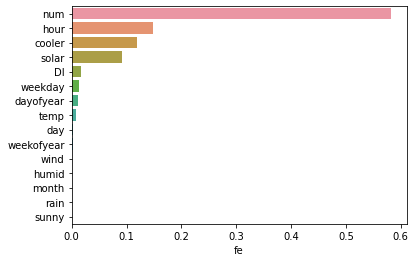

In [142]:
fe_avg = pd.DataFrame(np.mean(fe, axis=0),
                      index=x.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)
sns.barplot(fe_avg.fe, y=fe_avg.index)
plt.show()

### 다시 살펴봅시다

In [143]:
train

num    target  temp  wind  humid  rain  sunny  cooler  solar  month  \
0         1  8179.056  17.6   2.5   92.0   0.8    0.0     0.0    0.0      6   
1         1  8135.640  17.7   2.9   91.0   0.3    0.0     0.0    0.0      6   
2         1  8107.128  17.5   3.2   91.0   0.0    0.0     0.0    0.0      6   
3         1  8048.808  17.1   3.2   91.0   0.0    0.0     0.0    0.0      6   
4         1  8043.624  17.0   3.3   92.0   0.0    0.0     0.0    0.0      6   
...     ...       ...   ...   ...    ...   ...    ...     ...    ...    ...   
122395   60  4114.368  27.8   2.3   68.0   0.0    0.7     1.0    1.0      8   
122396   60  3975.696  27.3   1.2   71.0   0.0    0.0     1.0    1.0      8   
122397   60  3572.208  27.3   1.8   71.0   0.0    0.0     1.0    1.0      8   
122398   60  3299.184  27.1   1.8   74.0   0.0    0.0     1.0    1.0      8   
122399   60  3204.576  27.1   2.6   75.0   0.0    0.0     1.0    1.0      8   

        day  hour  weekday  dayofyear  weekofyear  
0         1     0        0        153          23  
1         1     1        0        153          23  
2         1     2        0        153          23  
3         1     3        0        153          23  
4         1     4        0        153          23  
...     ...   ...      ...        ...         ...  
122395   24    19        0        237          35  
122396   24    20        0        237          35  
122397   24    21        0        237          35  
122398   24    22        0        237          35  
122399   24    23        0        237          35  

[122400 rows x 15 columns]

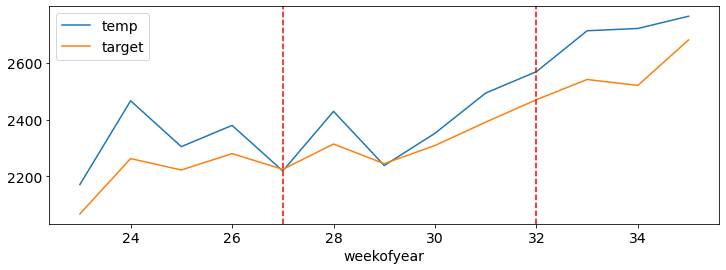

In [540]:
(train.groupby(['weekofyear'])['temp'].mean()*100).plot(figsize=(12, 4))
train.groupby(['weekofyear'])['target'].mean().plot(figsize=(12, 4))
plt.legend(['temp', 'target'])
plt.axvline(x = 27, color = 'r', linestyle = '--',)
plt.axvline(x = 32, color = 'r', linestyle = '--',)
plt.show()

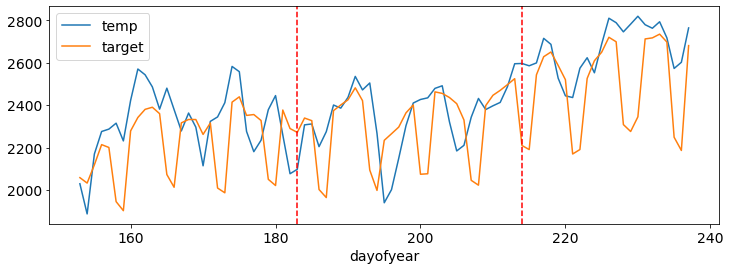

In [538]:
(train.groupby(['dayofyear'])['temp'].mean()*100).plot(figsize=(12, 4))
train.groupby(['dayofyear'])['target'].mean().plot(figsize=(12, 4))
plt.legend(['temp', 'target'])
plt.axvline(x = 183, color = 'r', linestyle = '--',)
plt.axvline(x = 214, color = 'r', linestyle = '--',)
plt.show()

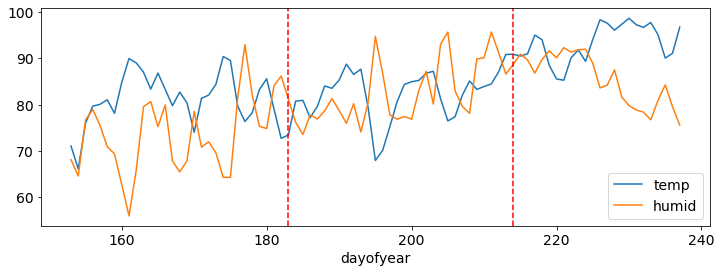

In [537]:
(train.groupby(['dayofyear'])['temp'].mean()*3.5).plot(figsize=(12, 4))
train.groupby(['dayofyear'])['humid'].mean().plot(figsize=(12, 4))
plt.legend(['temp', 'humid'])
plt.axvline(x = 183, color = 'r', linestyle = '--',)
plt.axvline(x = 214, color = 'r', linestyle = '--',)
plt.show()

- 여름이 끝나갈수록 기온은 올라가는 것을 알 수 있다.
- 7월은 장마의 영향이 있어보이며, 습도가 유독 높고 기온이 낮은 날이 많다.
- 8월은 장마의 영향에서 벗어나며 습도가 낮아지고, 기온이 높아지고 있다.
- 기온이 높아짐에 따라 전력 사용량도 같이 높아지는 경향을 보인다.

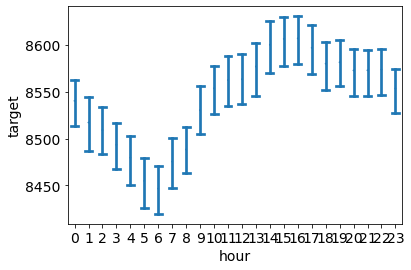

In [164]:
sns.pointplot(data=train.loc[train.num == 1, :],
            x='hour', y='target',
            kind='point', linestyles=[""], markers=["o"], capsize=.5, scale=.2)
plt.show()

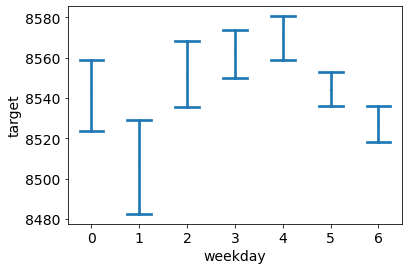

In [165]:
sns.pointplot(data=train.loc[train.num == 1, :],
            x='weekday', y='target',
            kind='point', linestyles=[""], markers=["o"], capsize=.5, scale=.2)
plt.show()

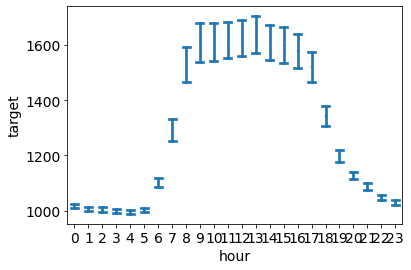

In [166]:
sns.pointplot(data=train.loc[train.num == 2, :],
            x='hour', y='target',
            kind='point', linestyles=[""], markers=["o"], capsize=.5, scale=.2)
plt.show()

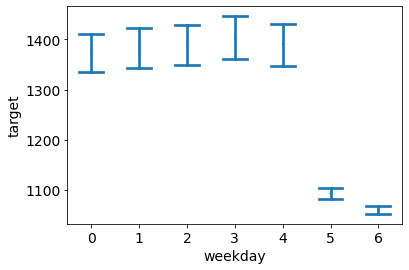

In [167]:
sns.pointplot(data=train.loc[train.num == 2, :],
            x='weekday', y='target',
            kind='point', linestyles=[""], markers=["o"], capsize=.5, scale=.2)
plt.show()

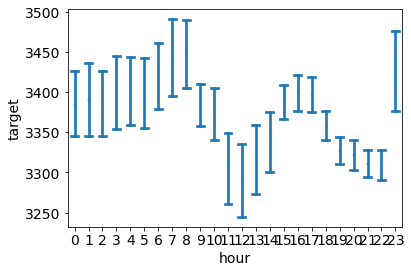

In [168]:
sns.pointplot(data=train.loc[train.num == 3, :],
            x='hour', y='target',
            kind='point', linestyles=[""], markers=["o"], capsize=.5, scale=.2)
plt.show()

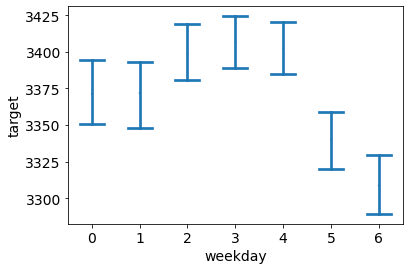

In [169]:
sns.pointplot(data=train.loc[train.num == 3, :],
            x='weekday', y='target',
            kind='point', linestyles=[""], markers=["o"], capsize=.5, scale=.2)
plt.show()

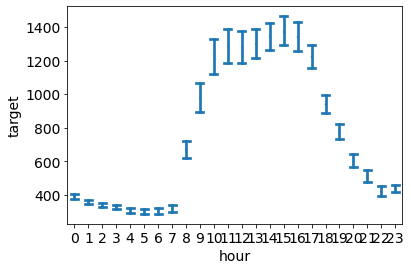

In [170]:
sns.pointplot(data=train.loc[train.num == 4, :],
            x='hour', y='target',
            kind='point', linestyles=[""], markers=["o"], capsize=.5, scale=.2)
plt.show()

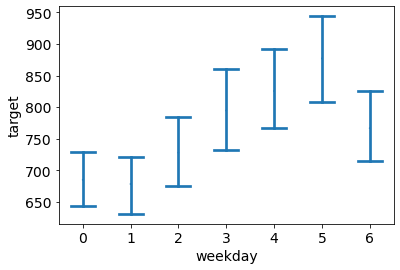

In [171]:
sns.pointplot(data=train.loc[train.num == 4, :],
            x='weekday', y='target',
            kind='point', linestyles=[""], markers=["o"], capsize=.5, scale=.2)
plt.show()

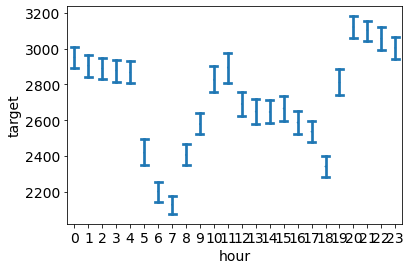

In [163]:
sns.pointplot(data=train.loc[train.num == 5, :],
            x='hour', y='target',
            kind='point', linestyles=[""], markers=["o"], capsize=.5, scale=.2)
plt.show()

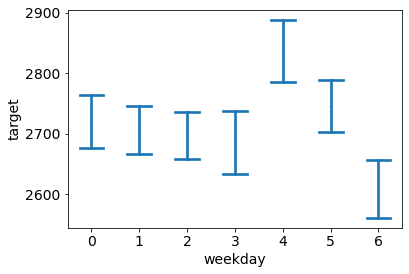

In [162]:
sns.pointplot(data=train.loc[train.num == 5, :],
            x='weekday', y='target',
            kind='point', linestyles=[""], markers=["o"], capsize=.5, scale=.2)
plt.show()

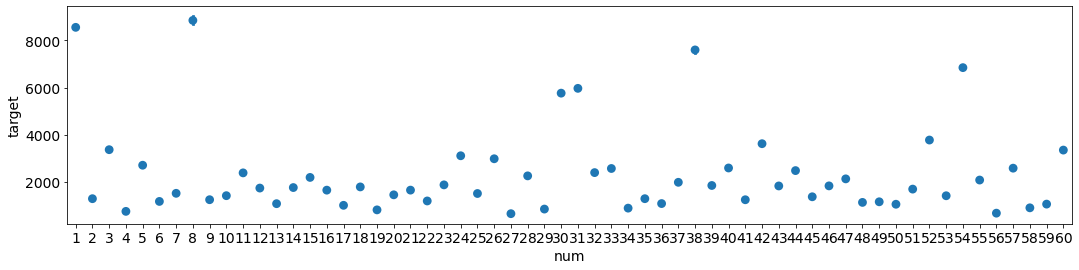

In [175]:
plt.figure(figsize=(18, 4))
sns.pointplot(data=train,
           x='num',
           y='target',
           linestyles=[""])
plt.show()

<AxesSubplot:xlabel='target', ylabel='hour'>

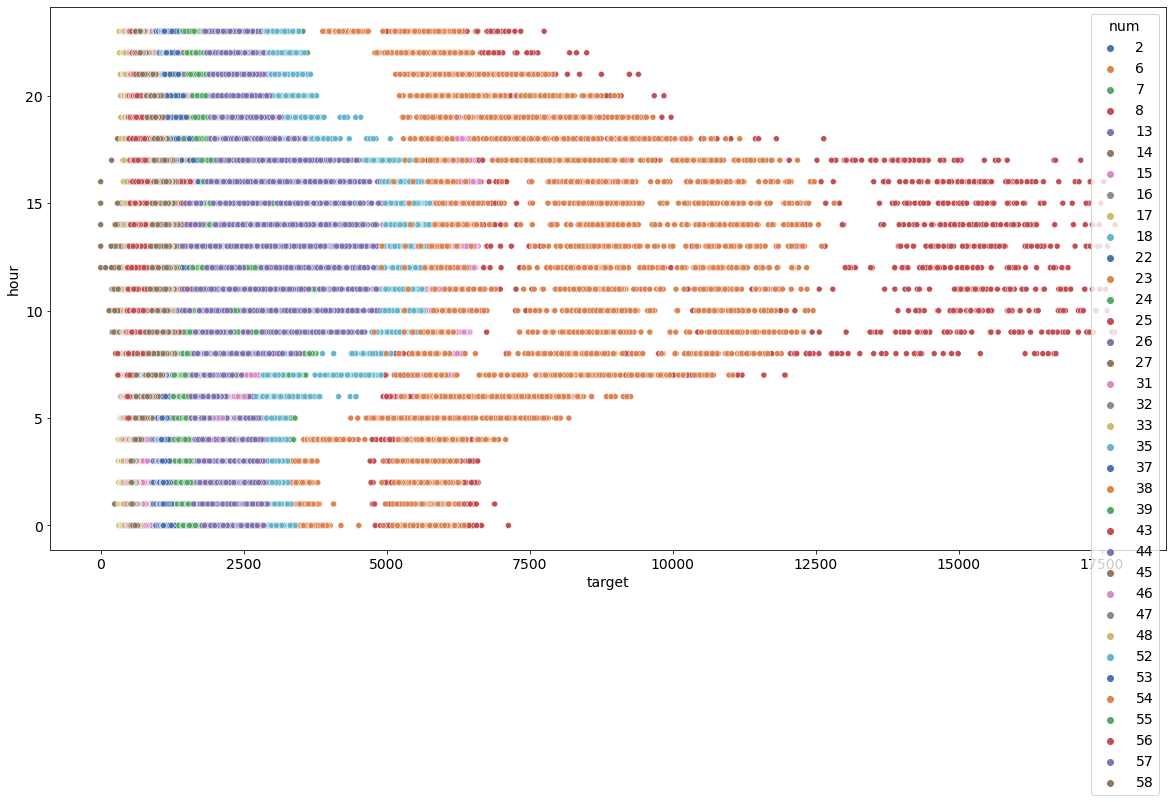

In [242]:
plt.figure(figsize=(20, 10))
sns.scatterplot(data=train_cl.loc[train_cl.km_cluster == 0],
               x='target',
               y='hour',
               hue='num',
               palette='deep')

<AxesSubplot:xlabel='target', ylabel='hour'>

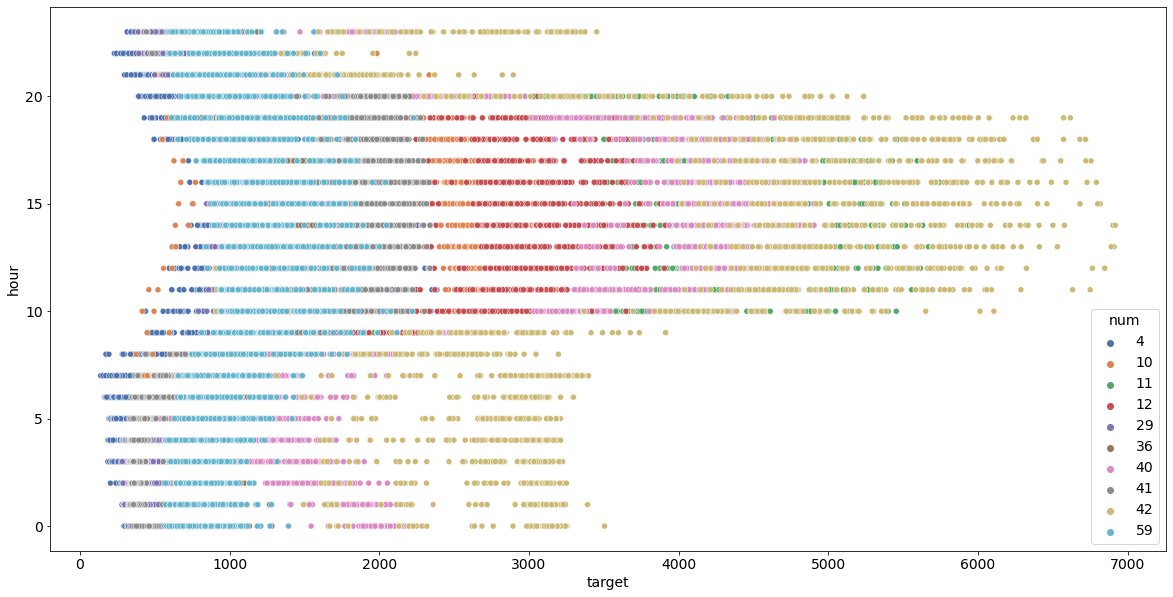

In [241]:
plt.figure(figsize=(20, 10))
sns.scatterplot(data=train_cl.loc[train_cl.km_cluster == 1],
               x='target',
               y='hour',
               hue='num',
               palette='deep')

<AxesSubplot:xlabel='target', ylabel='hour'>

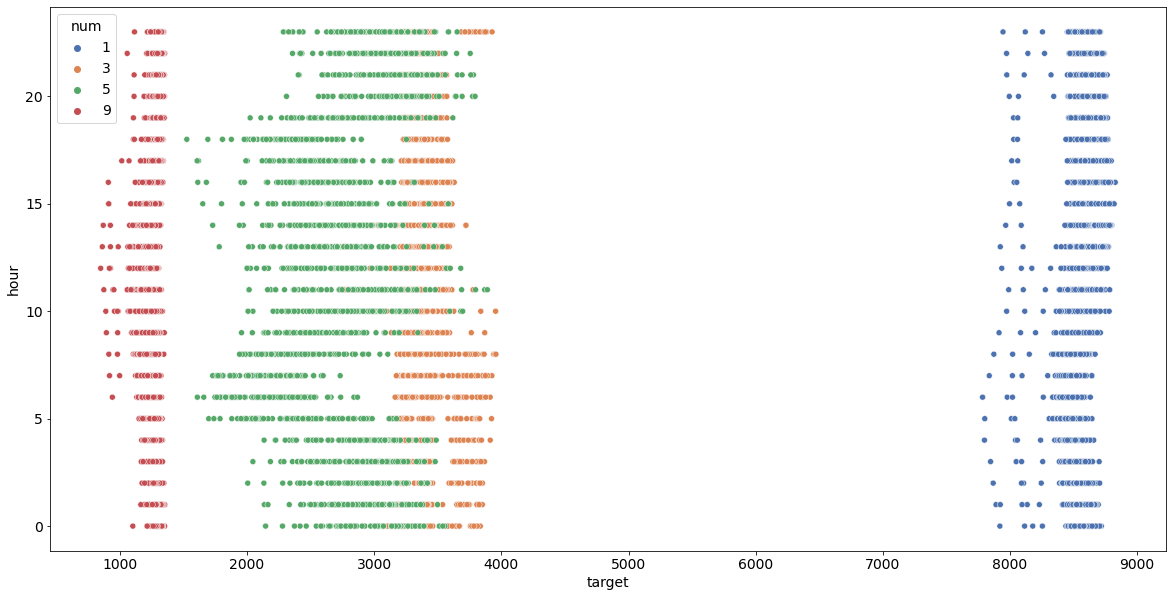

In [240]:
plt.figure(figsize=(20, 10))
sns.scatterplot(data=train_cl.loc[train_cl.km_cluster == 2],
               x='target',
               y='hour',
               hue='num',
               palette='deep')

<AxesSubplot:xlabel='target', ylabel='hour'>

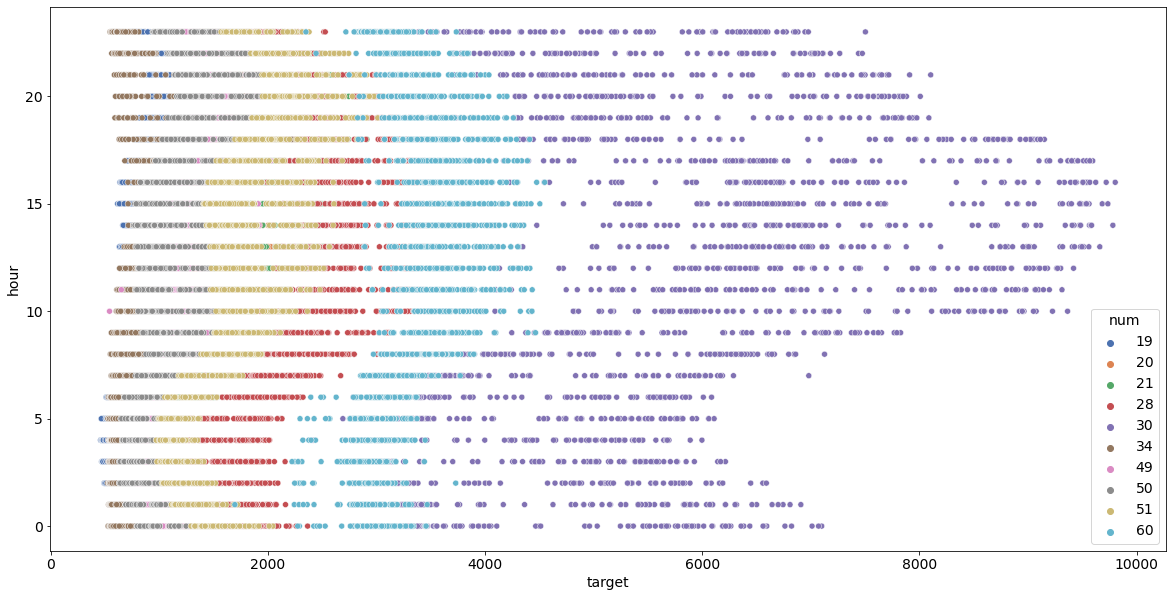

In [239]:
plt.figure(figsize=(20, 10))
sns.scatterplot(data=train_cl.loc[train_cl.km_cluster == 3],
               x='target',
               y='hour',
               hue='num',
               palette='deep')

In [248]:
train_cl.groupby(['km_cluster', 'hour', 'weekday'])['target'].mean().unstack()

weekday                    0            1            2            3  \
km_cluster hour                                                       
0          0     1829.438606  1894.220564  1919.980696  1930.819954   
           1     1809.232957  1861.756803  1884.504899  1897.023261   
           2     1789.096719  1839.383688  1862.007511  1872.049633   
           3     1765.599040  1808.743321  1830.251648  1846.535817   
           4     1776.824212  1813.682153  1832.327442  1848.894527   
...                      ...          ...          ...          ...   
3          19    2356.307380  2380.159062  2380.090356  2435.252625   
           20    2350.388622  2389.268484  2371.105400  2428.541775   
           21    2283.626911  2311.446070  2300.342112  2347.170799   
           22    2086.349398  2079.167228  2104.083920  2109.773538   
           23    1922.314558  1910.565000  1923.893003  1924.124069   

weekday                    4            5            6  
km_cluster hour                                         
0          0     1930.284596  1862.156475  1814.664097  
           1     1894.160812  1835.571348  1786.593264  
           2     1870.412167  1817.522546  1768.362379  
           3     1843.250167  1787.346061  1742.425705  
           4     1836.913801  1761.699053  1723.077753  
...                      ...          ...          ...  
3          19    2378.996143  2437.553700  2468.303325  
           20    2392.705010  2416.648275  2423.103975  
           21    2327.674888  2337.460875  2327.780250  
           22    2115.827213  2143.930381  2135.272613  
           23    1948.800428  1959.554051  1928.521247  

[96 rows x 7 columns]

<AxesSubplot:xlabel='weekday', ylabel='km_cluster-hour'>

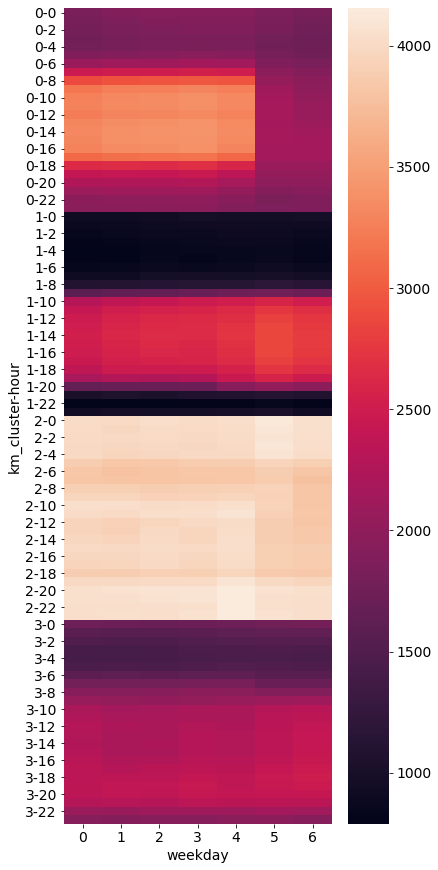

In [256]:
plt.figure(figsize=(6, 15))
sns.heatmap(train_cl.groupby(['km_cluster', 'hour', 'weekday'])['target'].mean().unstack())

- 0번 클러스터: 9-6의 시간에 가장 높은 전력사용량을 보이며, 주말과 새벽 시간에 사용량이 줄어드는 오피스 건물
- 1번 클러스터: 10-10의 시간에 가장 높은 전력사용량을 보이며, 평일주말 구분이 없는 상업 시설
- 2번 클러스터: 24시간, 모든 요일에 높은 전력사용량을 보이는, 공장? 발전시설? 등의 건물
- 3번 클러스터: 10-10의 시간에 가장 높은 전력사용량을 보이지만, 새벽 시간에도 사용량이 유지되는 상업 시설

In [286]:
cs_temp = train_cl.groupby(['km_cluster', 'num']).max().reset_index().groupby(['km_cluster'])['cooler', 'solar'].sum()

In [287]:
double_temp = train_cl[['km_cluster', 'num', 'solar', 'cooler']].drop_duplicates().set_index('num')
double_temp['double'] = double_temp.solar + double_temp.cooler

In [288]:
cs_temp['double'] = double_temp.loc[double_temp.double == 2].km_cluster.value_counts()

In [289]:
cs_temp['buildings'] = train_cl.groupby(['km_cluster'])['num'].count()/2040

In [290]:
cs_temp['cooler_rate'] = cs_temp.cooler / cs_temp.buildings
cs_temp['solar_rate'] = cs_temp.solar / cs_temp.buildings
cs_temp['double_rate'] = cs_temp.double / cs_temp.buildings

In [330]:
cs_temp

cooler  solar  double  buildings  cooler_rate  solar_rate  \
km_cluster                                                              
0             28.0   17.0      13       36.0     0.777778    0.472222   
1              7.0    5.0       4       10.0     0.700000    0.500000   
2              2.0    2.0       1        4.0     0.500000    0.500000   
3              4.0    5.0       3       10.0     0.400000    0.500000   

            double_rate  
km_cluster               
0              0.361111  
1              0.400000  
2              0.250000  
3              0.300000

<AxesSubplot:ylabel='km_cluster'>

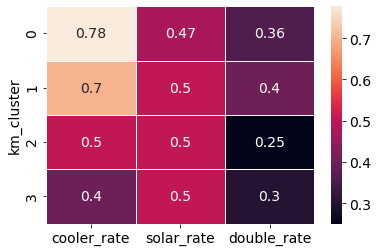

In [291]:
sns.heatmap(cs_temp[['cooler_rate', 'solar_rate', 'double_rate']],
           annot=True, linewidths=.5)

- solar는 모든 건물 유형에 유사한 비율을 가지고 있음
- cooler는 0 > 1 > 2 > 3 순으로 높은 비율을 가지고 있음
- 주간에 전력사용량이 집중되어 있는 0, 1 번 클러스터의 경우 cooler의 설치 비율이 높음
- 즉, 외부 온도에 민감한 건물이라는 것을 알 수 있고, 내부 온도를 낮게 유지시켜야 하는 건물임을 알 수 있음

In [292]:
from scipy.stats import pearsonr

In [325]:
corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].temp,
                       train.loc[train.num == i].target)
    corrs.append(corr)

In [326]:
corr_temp = train_cl.groupby(['num'])['km_cluster'].max().to_frame()
corr_temp['corr'] = corrs

In [327]:
corr_temp.groupby(['km_cluster']).mean()

corr
km_cluster          
0           0.460968
1           0.567722
2           0.244189
3           0.585945

<AxesSubplot:ylabel='km_cluster'>

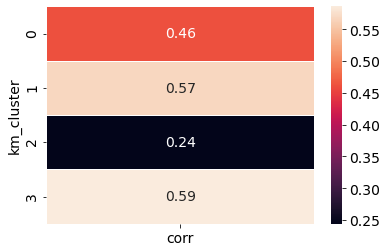

In [329]:
sns.heatmap(corr_temp.groupby(['km_cluster']).mean(),
           annot=True, linewidths=.5)

기온에 따른 전력 사용량의 상관관계는 크지 않은 편이다.

건물별로 기온, 습도, 일조, 불쾌지수에 대한 전력 사용량 상관도를 알아보자

In [421]:
corrs_temp = train_cl.groupby(['km_cluster', 'num'])['target'].mean().to_frame()

In [422]:
temp = train_cl.groupby(['num'])['cooler', 'solar'].max()

In [445]:
corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].temp,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['temp_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].humid,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['humid_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].sunny,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['sunny_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train_cl.loc[train.num == i].DI,
                       train_cl.loc[train.num == i].target)
    corrs.append(corr)
temp['DI_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train_cl.loc[train.num == i].hour,
                       train_cl.loc[train.num == i].target)
    corrs.append(corr)
temp['hour_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train_cl.loc[train.num == i].dayofyear,
                       train_cl.loc[train.num == i].target)
    corrs.append(corr)
temp['dayofyear_corr'] = corrs

In [446]:
corrs_cl_temp = pd.merge(corrs_temp, temp, how='left', on='num').set_index(corrs_temp.index).round(2)

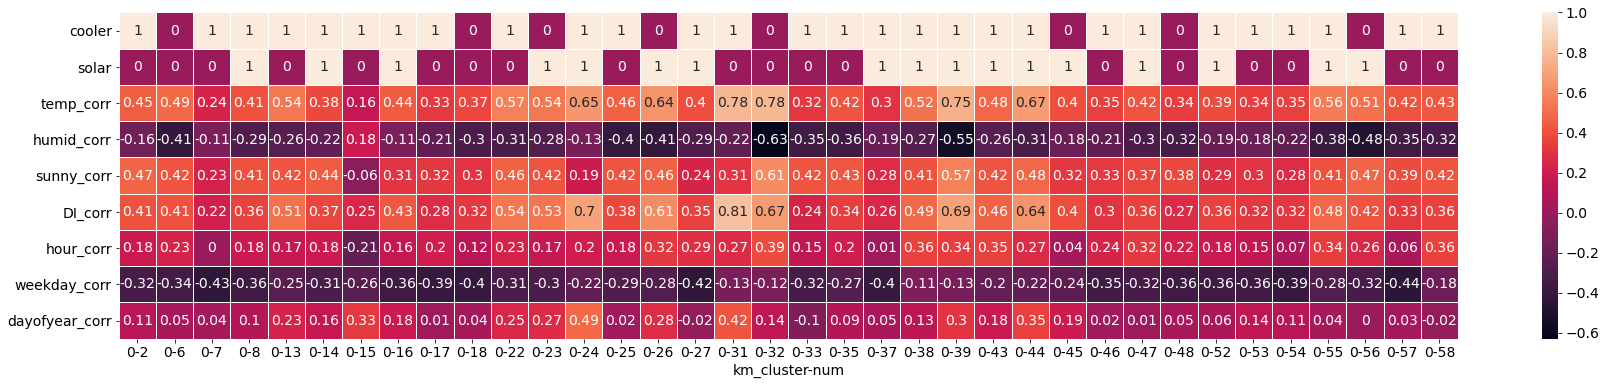

In [451]:
plt.figure(figsize=(30, 6))
sns.heatmap(corrs_cl_temp.iloc[:36, ~corrs_cl_temp.columns.isin(['num', 'target'])].T,
           annot=True, linewidths=.5)
plt.show()

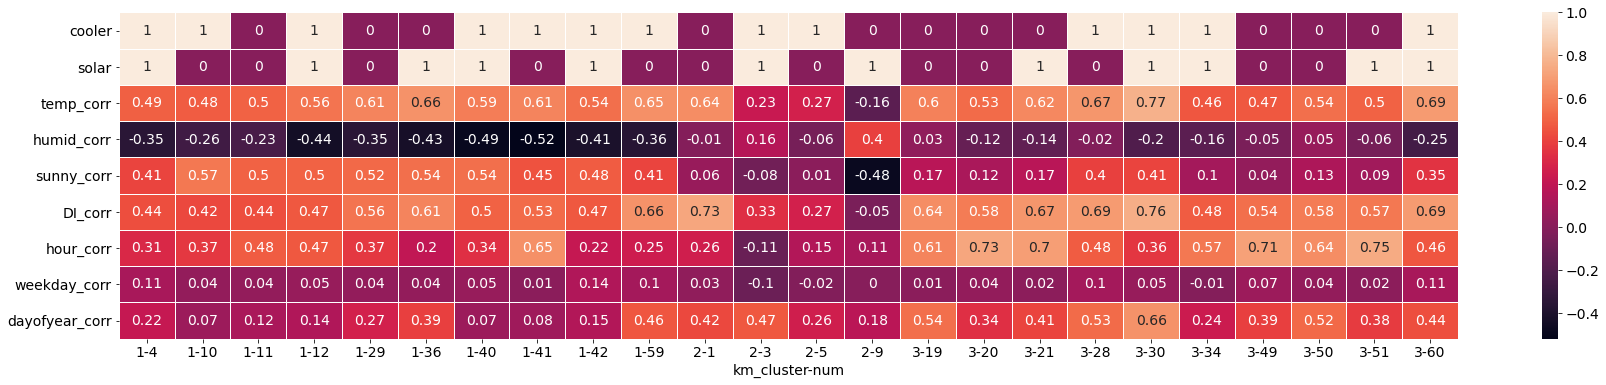

In [450]:
plt.figure(figsize=(30, 6))
sns.heatmap(corrs_cl_temp.iloc[36:, ~corrs_cl_temp.columns.isin(['num', 'target'])].T,
           annot=True, linewidths=.5)
plt.show()

- 1번 클러스터에서 습도에 대한 상관성이 높게 나타나는 경향이 있다.
- 2, 3번 클러스터는 반대로 습도에 대한 상관성이 매우 낮다.
- 2, 3번 클러스터에서 일조량에 대한 상관성이 매우 낮게 나타나는 경향이 있다.
- 2-9번 건물은 매우 특이한 건물이다. 유일하게 기온데 대해 음의 상관성을 보이며, 일조량에 대해서 매우 강한 음의 상관성을 보인다. 반대로 습도에 대해서는 매우 높은 양의 상관성을 보인다.
- 2-9번 건물 같은 경우는 따로 모델링을 해야 할 정도라고 본다.
- 1번 클러스터는 시간이 지남에 따른 전력 사용량의 상관관계가 없지만, 2, 3번 클러스터는 상관성을 띄고 있다.

In [668]:
temp = (
    corrs_cl_temp
    .reset_index()
    .groupby(['km_cluster'])
    .mean()[['temp_corr', 'humid_corr', 'sunny_corr', 'DI_corr', 'hour_corr', 'weekday_corr', 'dayofyear_corr']]
    .T
)

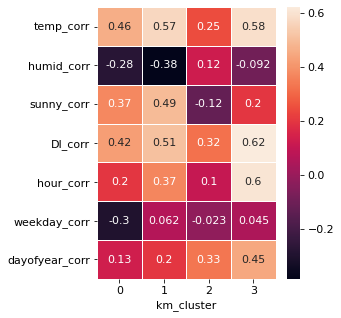

In [669]:
plt.rcParams["font.size"] = "11"
plt.figure(figsize=(4, 5))
sns.heatmap(temp,
           annot=True, linewidths=.5)
plt.show()

In [653]:
(
    corrs_cl_temp
    .reset_index()
    .groupby(['km_cluster'])
    .mean()[['temp_corr', 'humid_corr', 'sunny_corr',
             'DI_corr', 'hour_corr', 'weekday_corr', 'dayofyear_corr']]
)

temp_corr  humid_corr  sunny_corr   DI_corr  hour_corr  \
km_cluster                                                           
0            0.461111   -0.277222    0.370556  0.421944   0.199444   
1            0.569000   -0.384000    0.492000  0.510000   0.366000   
2            0.245000    0.122500   -0.122500  0.320000   0.102500   
3            0.585000   -0.092000    0.198000  0.620000   0.601000   

            weekday_corr  dayofyear_corr  
km_cluster                                
0              -0.298333        0.131389  
1               0.062000        0.197000  
2              -0.022500        0.332500  
3               0.045000        0.445000

In [469]:
corrs_cl_temp.reset_index().head()

km_cluster  num   target  cooler  solar  temp_corr  humid_corr  sunny_corr  \
0           0    2  1299.91     1.0    0.0       0.45       -0.16        0.47   
1           0    6  1184.13     0.0    0.0       0.49       -0.41        0.42   
2           0    7  1527.14     1.0    0.0       0.24       -0.11        0.23   
3           0    8  8837.36     1.0    1.0       0.41       -0.29        0.41   
4           0   13  1089.12     1.0    0.0       0.54       -0.26        0.42   

   DI_corr  hour_corr  weekday_corr  dayofyear_corr  
0     0.41       0.18         -0.32            0.11  
1     0.41       0.23         -0.34            0.05  
2     0.22       0.00         -0.43            0.04  
3     0.36       0.18         -0.36            0.10  
4     0.51       0.17         -0.25            0.23

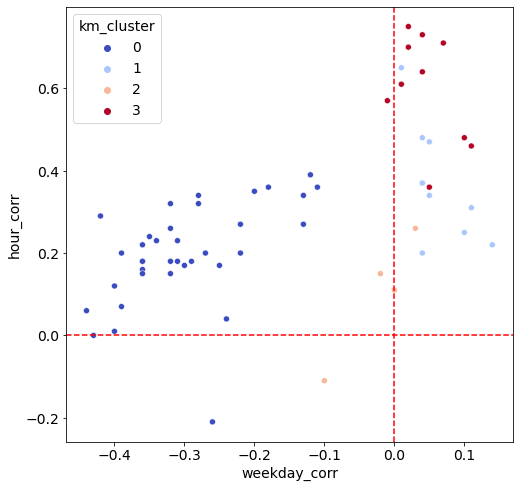

In [490]:
plt.figure(figsize=(8, 8))
sns.scatterplot(data=corrs_cl_temp.reset_index(), x='weekday_corr', y='hour_corr', hue='km_cluster', palette='coolwarm')
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.axvline(x = 0, color = 'r', linestyle = '--')

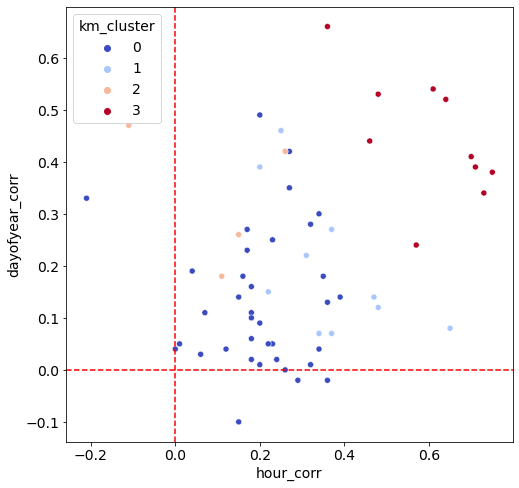

In [487]:
plt.figure(figsize=(8, 8))
sns.scatterplot(data=corrs_cl_temp.reset_index(), x='hour_corr', y='dayofyear_corr', hue='km_cluster', palette='coolwarm')
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.axvline(x = 0, color = 'r', linestyle = '--')

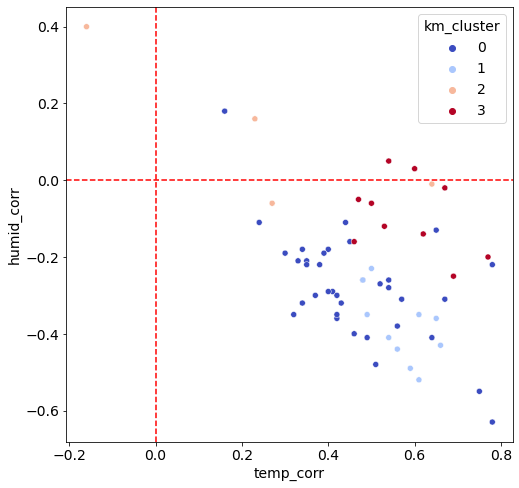

In [488]:
plt.figure(figsize=(8, 8))
sns.scatterplot(data=corrs_cl_temp.reset_index(), x='temp_corr', y='humid_corr', hue='km_cluster', palette='coolwarm')
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.axvline(x = 0, color = 'r', linestyle = '--')

In [542]:
train

num    target  temp  wind  humid  rain  sunny  cooler  solar  month  \
0         1  8179.056  17.6   2.5   92.0   0.8    0.0     0.0    0.0      6   
1         1  8135.640  17.7   2.9   91.0   0.3    0.0     0.0    0.0      6   
2         1  8107.128  17.5   3.2   91.0   0.0    0.0     0.0    0.0      6   
3         1  8048.808  17.1   3.2   91.0   0.0    0.0     0.0    0.0      6   
4         1  8043.624  17.0   3.3   92.0   0.0    0.0     0.0    0.0      6   
...     ...       ...   ...   ...    ...   ...    ...     ...    ...    ...   
122395   60  4114.368  27.8   2.3   68.0   0.0    0.7     1.0    1.0      8   
122396   60  3975.696  27.3   1.2   71.0   0.0    0.0     1.0    1.0      8   
122397   60  3572.208  27.3   1.8   71.0   0.0    0.0     1.0    1.0      8   
122398   60  3299.184  27.1   1.8   74.0   0.0    0.0     1.0    1.0      8   
122399   60  3204.576  27.1   2.6   75.0   0.0    0.0     1.0    1.0      8   

        day  hour  weekday  dayofyear  weekofyear  month_start  month_end  
0         1     0        0        153          23         True      False  
1         1     1        0        153          23         True      False  
2         1     2        0        153          23         True      False  
3         1     3        0        153          23         True      False  
4         1     4        0        153          23         True      False  
...     ...   ...      ...        ...         ...          ...        ...  
122395   24    19        0        237          35        False      False  
122396   24    20        0        237          35        False      False  
122397   24    21        0        237          35        False      False  
122398   24    22        0        237          35        False      False  
122399   24    23        0        237          35        False      False  

[122400 rows x 17 columns]

### 일조량과 태양광은 연관성이 있을까?

In [612]:
train_sunny = train_cl.copy()

In [613]:
scaled = []
for i in range(1, 61):
    mean_ = train_sunny.loc[train_sunny.num == i, 'target'].mean()
    std_ = train_sunny.loc[train_sunny.num == i, 'target'].std()
    train_sunny.loc[train_sunny.num == i, 'target'] = (mean_ - train_sunny.loc[train_sunny.num == i, 'target']) / std_

<AxesSubplot:xlabel='dayofyear'>

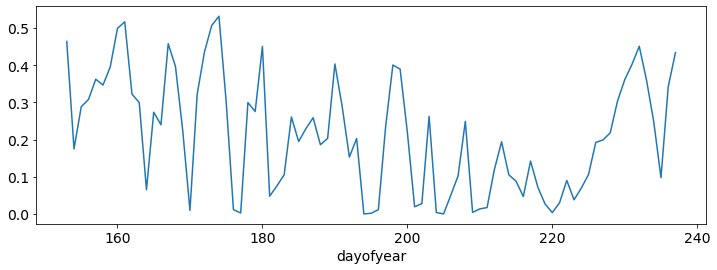

In [623]:
train_cl.groupby(['dayofyear'])['sunny'].mean().plot(figsize=(12, 4))

In [640]:
train_cl

num    target  temp  wind  humid  rain  sunny  cooler  solar  month  \
0         1  8179.056  17.6   2.5   92.0   0.8    0.0     0.0    0.0      6   
1         1  8135.640  17.7   2.9   91.0   0.3    0.0     0.0    0.0      6   
2         1  8107.128  17.5   3.2   91.0   0.0    0.0     0.0    0.0      6   
3         1  8048.808  17.1   3.2   91.0   0.0    0.0     0.0    0.0      6   
4         1  8043.624  17.0   3.3   92.0   0.0    0.0     0.0    0.0      6   
...     ...       ...   ...   ...    ...   ...    ...     ...    ...    ...   
122395   60  4114.368  27.8   2.3   68.0   0.0    0.7     1.0    1.0      8   
122396   60  3975.696  27.3   1.2   71.0   0.0    0.0     1.0    1.0      8   
122397   60  3572.208  27.3   1.8   71.0   0.0    0.0     1.0    1.0      8   
122398   60  3299.184  27.1   1.8   74.0   0.0    0.0     1.0    1.0      8   
122399   60  3204.576  27.1   2.6   75.0   0.0    0.0     1.0    1.0      8   

        day  hour  weekday  dayofyear  weekofyear  month_start  month_end  \
0         1     0        0        153          23         True      False   
1         1     1        0        153          23         True      False   
2         1     2        0        153          23         True      False   
3         1     3        0        153          23         True      False   
4         1     4        0        153          23         True      False   
...     ...   ...      ...        ...         ...          ...        ...   
122395   24    19        0        237          35        False      False   
122396   24    20        0        237          35        False      False   
122397   24    21        0        237          35        False      False   
122398   24    22        0        237          35        False      False   
122399   24    23        0        237          35        False      False   

        km_cluster     DI  
0                2  63.43  
1                2  63.57  
2                2  63.23  
3                2  62.54  
4                2  62.40  
...            ...    ...  
122395           3  77.81  
122396           3  77.45  
122397           3  77.45  
122398           3  77.52  
122399           3  77.65  

[122400 rows x 19 columns]

### 휴일과 주말을 넣어주자

In [685]:
# 6월 6일은 현충일
# 8월 15일은 광복절
# 8월 17일은 임시공휴일

# 휴일이 많지 않으니, 주말에 포함시키자.

train.loc[train.weekday >= 5, 'holiday'] = True
train.loc[train.weekday < 5, 'holiday'] = False
train.loc[(train.month == 8) & (train.day == 17), 'holiday'] = True

test.loc[test.weekday >= 5, 'holiday'] = True
test.loc[test.weekday < 5, 'holiday'] = False

In [686]:
train

num    target  temp  wind  humid  rain  sunny  cooler  solar  month  \
0         1  8179.056  17.6   2.5   92.0   0.8    0.0     0.0    0.0      6   
1         1  8135.640  17.7   2.9   91.0   0.3    0.0     0.0    0.0      6   
2         1  8107.128  17.5   3.2   91.0   0.0    0.0     0.0    0.0      6   
3         1  8048.808  17.1   3.2   91.0   0.0    0.0     0.0    0.0      6   
4         1  8043.624  17.0   3.3   92.0   0.0    0.0     0.0    0.0      6   
...     ...       ...   ...   ...    ...   ...    ...     ...    ...    ...   
122395   60  4114.368  27.8   2.3   68.0   0.0    0.7     1.0    1.0      8   
122396   60  3975.696  27.3   1.2   71.0   0.0    0.0     1.0    1.0      8   
122397   60  3572.208  27.3   1.8   71.0   0.0    0.0     1.0    1.0      8   
122398   60  3299.184  27.1   1.8   74.0   0.0    0.0     1.0    1.0      8   
122399   60  3204.576  27.1   2.6   75.0   0.0    0.0     1.0    1.0      8   

        day  hour  weekday  dayofyear  weekofyear  month_start  month_end  \
0         1     0        0        153          23         True      False   
1         1     1        0        153          23         True      False   
2         1     2        0        153          23         True      False   
3         1     3        0        153          23         True      False   
4         1     4        0        153          23         True      False   
...     ...   ...      ...        ...         ...          ...        ...   
122395   24    19        0        237          35        False      False   
122396   24    20        0        237          35        False      False   
122397   24    21        0        237          35        False      False   
122398   24    22        0        237          35        False      False   
122399   24    23        0        237          35        False      False   

       holiday  
0        False  
1        False  
2        False  
3        False  
4        False  
...        ...  
122395   False  
122396   False  
122397   False  
122398   False  
122399   False  

[122400 rows x 18 columns]

In [687]:
for i in range(1, 61):
    # 빌딩별로 train_x을 만듭니다.
    globals()['train_building_{}'.format(i)] = train.loc[train.num == i,
                                                         ~train.columns.isin(['target', 'num', 'cooler', 'solar'])]
    
    # 빌딩별로 train_y 를 만듭니다.
    globals()['train_building_{}_y'.format(i)] = train.loc[train.num == i, 'target']
    
    # 빌딩별로 test_x 를 만듭니다.
    globals()['test_building_{}'.format(i)] = test.loc[test.num == i,
                                                       ~test.columns.isin(['num', 'cooler', 'solar'])]

In [688]:
train_building_60.shape, train_building_60_y.shape, test_building_60.shape

((2040, 14), (2040,), (168, 14))

In [689]:
preds = []
fe = []
oob_scores = []
for i in tqdm(range(1, 61)):
    rf = RandomForestRegressor(random_state=42, oob_score=True)
    rf.fit(globals()['train_building_{}'.format(i)], globals()['train_building_{}_y'.format(i)])
    pred = rf.predict(globals()['test_building_{}'.format(i)])
    preds.append(pred.tolist())
    fe.append(rf.feature_importances_)
    oob_scores.append(rf.oob_score_)
    
print(np.std(oob_scores), np.mean(oob_scores))

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:37<00:00,  1.58it/s]

0.0581691586922366 0.9531575966220359


In [691]:
preds = sum(preds, [])

In [692]:
sub.answer = preds

In [694]:
sub.to_csv('submission/210608_537316+holiday.csv', index=False)
sub

num_date_time      answer
0       1 2020-08-25 00  8670.35016
1       1 2020-08-25 01  8667.75168
2       1 2020-08-25 02  8665.35408
3       1 2020-08-25 03  8658.63432
4       1 2020-08-25 04  8653.11984
...                 ...         ...
10075  60 2020-08-31 19  4064.82624
10076  60 2020-08-31 20  4014.52416
10077  60 2020-08-31 21  3839.38272
10078  60 2020-08-31 22  3520.99440
10079  60 2020-08-31 23  3388.07232

[10080 rows x 2 columns]

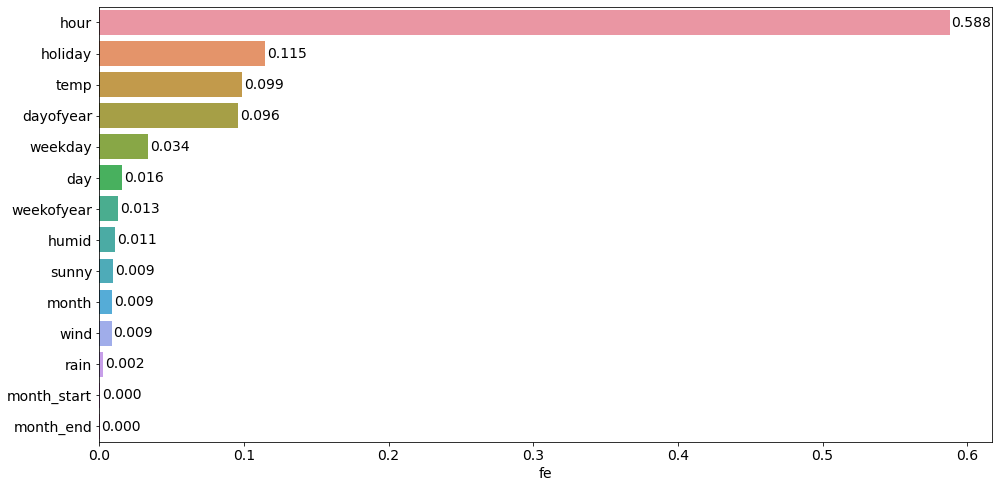

In [690]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fe, axis=0),
                      index=train_building_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(16, 8))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

In [695]:
train

num    target  temp  wind  humid  rain  sunny  cooler  solar  month  \
0         1  8179.056  17.6   2.5   92.0   0.8    0.0     0.0    0.0      6   
1         1  8135.640  17.7   2.9   91.0   0.3    0.0     0.0    0.0      6   
2         1  8107.128  17.5   3.2   91.0   0.0    0.0     0.0    0.0      6   
3         1  8048.808  17.1   3.2   91.0   0.0    0.0     0.0    0.0      6   
4         1  8043.624  17.0   3.3   92.0   0.0    0.0     0.0    0.0      6   
...     ...       ...   ...   ...    ...   ...    ...     ...    ...    ...   
122395   60  4114.368  27.8   2.3   68.0   0.0    0.7     1.0    1.0      8   
122396   60  3975.696  27.3   1.2   71.0   0.0    0.0     1.0    1.0      8   
122397   60  3572.208  27.3   1.8   71.0   0.0    0.0     1.0    1.0      8   
122398   60  3299.184  27.1   1.8   74.0   0.0    0.0     1.0    1.0      8   
122399   60  3204.576  27.1   2.6   75.0   0.0    0.0     1.0    1.0      8   

        day  hour  weekday  dayofyear  weekofyear  month_start  month_end  \
0         1     0        0        153          23         True      False   
1         1     1        0        153          23         True      False   
2         1     2        0        153          23         True      False   
3         1     3        0        153          23         True      False   
4         1     4        0        153          23         True      False   
...     ...   ...      ...        ...         ...          ...        ...   
122395   24    19        0        237          35        False      False   
122396   24    20        0        237          35        False      False   
122397   24    21        0        237          35        False      False   
122398   24    22        0        237          35        False      False   
122399   24    23        0        237          35        False      False   

       holiday  
0        False  
1        False  
2        False  
3        False  
4        False  
...        ...  
122395   False  
122396   False  
122397   False  
122398   False  
122399   False  

[122400 rows x 18 columns]

# 프레임 짜기

전력을 사용하는 것에는 많은 원인이 있다.
 - 조명을 켠다.
 - 난방을 한다.(본 데이터의 경우)
 - 전자기기를 켠다.

한국 에너지 공단은 최근 에너지 효율 향상을 위해 건물 부문에서 많은 사업을 진행하고 있다.

건물의 에너지 관리 시스템을 구축하거나, 효율 등급이 좋은 건물에 대한 인증을 제공한다.

비전기냉방시스템은 전력을 쓰지 않으면서 냉방을 할 수 있는, KEA가 가장 좋아할만 한 시스템이다.

태양광 발전도 마찬가지다.

건물에 대한 어떠한 정보도 주지 않으면서도 이 두 가지 정보를 주었다는 것은 분명 무슨 의미가 있다.

그렇다면 전력 소모량을 줄일 수 있는 힌트를 이 데이터에서 얻을 수 있을까?

예측을 기반으로 전력 소모량을 줄이는 방법을 찾는다면, 그것은 역시 예측된 전력 사용량 대비 사용된 전력 사용량이 적은 건물에 대한 인센티브를 주는 것이다. 또한 그것이 비전기냉방시설과 태양광발전의 도움을 받았다면 더욱 큰 인센티브를 줄 수 있다.

전력 사용량의 차이가 나는 것은 건물의 크기와 매우 밀접한 관련이 있을 것이다.

건물의 유형별로 인센티브 제도에 차등을 줄 수 있을 것 같다.

24시간 균등하게 돌아가는 건물의 경우에는 쉽지 않을 수 있다.

다만 오피스 건물 같은 경우에는 낮 시간대의 절약을 통해 충분히 줄일 수 있다.

상가 건물들도 마찬가지다.

즉, 내가 제안하고 싶은 건, 건물 유형 별 전력 사용량 절약 목표 달성 캠페인이다.

테스트를 위해서 train 기간의 최근 1주일에 대한 예측과 실제 사용량을 비교해보자

In [696]:
train

num    target  temp  wind  humid  rain  sunny  cooler  solar  month  \
0         1  8179.056  17.6   2.5   92.0   0.8    0.0     0.0    0.0      6   
1         1  8135.640  17.7   2.9   91.0   0.3    0.0     0.0    0.0      6   
2         1  8107.128  17.5   3.2   91.0   0.0    0.0     0.0    0.0      6   
3         1  8048.808  17.1   3.2   91.0   0.0    0.0     0.0    0.0      6   
4         1  8043.624  17.0   3.3   92.0   0.0    0.0     0.0    0.0      6   
...     ...       ...   ...   ...    ...   ...    ...     ...    ...    ...   
122395   60  4114.368  27.8   2.3   68.0   0.0    0.7     1.0    1.0      8   
122396   60  3975.696  27.3   1.2   71.0   0.0    0.0     1.0    1.0      8   
122397   60  3572.208  27.3   1.8   71.0   0.0    0.0     1.0    1.0      8   
122398   60  3299.184  27.1   1.8   74.0   0.0    0.0     1.0    1.0      8   
122399   60  3204.576  27.1   2.6   75.0   0.0    0.0     1.0    1.0      8   

        day  hour  weekday  dayofyear  weekofyear  month_start  month_end  \
0         1     0        0        153          23         True      False   
1         1     1        0        153          23         True      False   
2         1     2        0        153          23         True      False   
3         1     3        0        153          23         True      False   
4         1     4        0        153          23         True      False   
...     ...   ...      ...        ...         ...          ...        ...   
122395   24    19        0        237          35        False      False   
122396   24    20        0        237          35        False      False   
122397   24    21        0        237          35        False      False   
122398   24    22        0        237          35        False      False   
122399   24    23        0        237          35        False      False   

       holiday  
0        False  
1        False  
2        False  
3        False  
4        False  
...        ...  
122395   False  
122396   False  
122397   False  
122398   False  
122399   False  

[122400 rows x 18 columns]

In [824]:
train = pd.read_csv(PATH + '\\train.csv', encoding='cp949', names=train_col, header=0)

In [825]:
train['datetime'] = pd.to_datetime(train.date_time)

In [826]:
X = train.loc[train.date_time < '2020-08-18']
y = train.loc[train.date_time >= '2020-08-18']

In [827]:
def make_time(train):
    train['datetime'] = pd.to_datetime(train.date_time)
    
    train['month'] = train.datetime.dt.month                    # 월(숫자)
    train['day'] = train.datetime.dt.day                        # 일(숫자)
    train['hour'] = train.datetime.dt.hour                      # 시(숫자)
    train['weekday'] = train.datetime.dt.weekday                # 시(숫자)
    train['dayofyear'] = train.datetime.dt.dayofyear            # 연 기준 몇일째(숫자)
    train['weekofyear'] = train.datetime.dt.isocalendar().week  # 연 기준 몇주째(숫자) (=week)
    
    # 2차 time / 지지
    train['month_start'] = train.datetime.dt.is_month_start
    train['month_end'] = train.datetime.dt.is_month_end
    
    # 여기까지
    
    train.drop(['date_time'], axis=1, inplace=True)
    
    train.weekofyear = train.weekofyear.astype(int)
    
    return train

In [828]:
X = make_time(X)
y = make_time(y)

In [829]:
X

num    target  temp  wind  humid  rain  sunny  cooler  solar  \
0         1  8179.056  17.6   2.5   92.0   0.8    0.0     0.0    0.0   
1         1  8135.640  17.7   2.9   91.0   0.3    0.0     0.0    0.0   
2         1  8107.128  17.5   3.2   91.0   0.0    0.0     0.0    0.0   
3         1  8048.808  17.1   3.2   91.0   0.0    0.0     0.0    0.0   
4         1  8043.624  17.0   3.3   92.0   0.0    0.0     0.0    0.0   
...     ...       ...   ...   ...    ...   ...    ...     ...    ...   
122227   60  4261.248  28.0   1.2   81.0   0.0    0.9     1.0    1.0   
122228   60  4202.064  26.8   2.1   86.0   0.0    0.0     1.0    1.0   
122229   60  4036.608  26.0   2.1   92.0   0.0    0.0     1.0    1.0   
122230   60  3850.416  25.8   1.0   87.0   0.0    0.0     1.0    1.0   
122231   60  3297.888  25.6   1.3   84.0   0.0    0.0     1.0    1.0   

                  datetime  month  day  hour  weekday  dayofyear  weekofyear  \
0      2020-06-01 00:00:00      6    1     0        0        153          23   
1      2020-06-01 01:00:00      6    1     1        0        153          23   
2      2020-06-01 02:00:00      6    1     2        0        153          23   
3      2020-06-01 03:00:00      6    1     3        0        153          23   
4      2020-06-01 04:00:00      6    1     4        0        153          23   
...                    ...    ...  ...   ...      ...        ...         ...   
122227 2020-08-17 19:00:00      8   17    19        0        230          34   
122228 2020-08-17 20:00:00      8   17    20        0        230          34   
122229 2020-08-17 21:00:00      8   17    21        0        230          34   
122230 2020-08-17 22:00:00      8   17    22        0        230          34   
122231 2020-08-17 23:00:00      8   17    23        0        230          34   

        month_start  month_end  
0              True      False  
1              True      False  
2              True      False  
3              True      False  
4              True      False  
...             ...        ...  
122227        False      False  
122228        False      False  
122229        False      False  
122230        False      False  
122231        False      False  

[112320 rows x 18 columns]

In [830]:
y

num    target  temp  wind  humid  rain  sunny  cooler  solar  \
1872      1  8690.976  26.2   0.9   84.0   0.0    0.0     0.0    0.0   
1873      1  8672.184  25.7   0.9   86.0   0.0    0.0     0.0    0.0   
1874      1  8645.616  25.4   0.6   88.0   0.0    0.0     0.0    0.0   
1875      1  8583.408  25.0   0.4   89.0   0.0    0.0     0.0    0.0   
1876      1  8562.672  24.8   0.6   90.0   0.0    0.0     0.0    0.0   
...     ...       ...   ...   ...    ...   ...    ...     ...    ...   
122395   60  4114.368  27.8   2.3   68.0   0.0    0.7     1.0    1.0   
122396   60  3975.696  27.3   1.2   71.0   0.0    0.0     1.0    1.0   
122397   60  3572.208  27.3   1.8   71.0   0.0    0.0     1.0    1.0   
122398   60  3299.184  27.1   1.8   74.0   0.0    0.0     1.0    1.0   
122399   60  3204.576  27.1   2.6   75.0   0.0    0.0     1.0    1.0   

                  datetime  month  day  hour  weekday  dayofyear  weekofyear  \
1872   2020-08-18 00:00:00      8   18     0        1        231          34   
1873   2020-08-18 01:00:00      8   18     1        1        231          34   
1874   2020-08-18 02:00:00      8   18     2        1        231          34   
1875   2020-08-18 03:00:00      8   18     3        1        231          34   
1876   2020-08-18 04:00:00      8   18     4        1        231          34   
...                    ...    ...  ...   ...      ...        ...         ...   
122395 2020-08-24 19:00:00      8   24    19        0        237          35   
122396 2020-08-24 20:00:00      8   24    20        0        237          35   
122397 2020-08-24 21:00:00      8   24    21        0        237          35   
122398 2020-08-24 22:00:00      8   24    22        0        237          35   
122399 2020-08-24 23:00:00      8   24    23        0        237          35   

        month_start  month_end  
1872          False      False  
1873          False      False  
1874          False      False  
1875          False      False  
1876          False      False  
...             ...        ...  
122395        False      False  
122396        False      False  
122397        False      False  
122398        False      False  
122399        False      False  

[10080 rows x 18 columns]

구할건 빌딩별로 7일간의 pred 입니다.

그러려면 각각의 빌딩별로 x_train, y_train, x_test, y_test 를 구해서 fit, predict 를 해야겠죠?

X, y 를 통해서 진행해보도록 합시다.

In [831]:
for i in range(1, 61):
    # 빌딩별로 x_train을 만듭니다.
    globals()['x_train_{}'.format(i)] = X.loc[X.num == i,
                                              ~X.columns.isin(['target', 'num', 'cooler', 'solar', 'datetime'])]
    
    # 빌딩별로 y_train 를 만듭니다.
    globals()['y_train_{}'.format(i)] = X.loc[X.num == i, 'target']
    
    # 빌딩별로 x_test 를 만듭니다.
    globals()['x_test_{}'.format(i)] = y.loc[y.num == i,
                                             ~y.columns.isin(['target', 'num', 'cooler', 'solar', 'datetime'])]
    
    # 빌딩별로 y_test 를 만듭니다.
    globals()['y_test_{}'.format(i)] = y.loc[y.num == i, 'target']

In [832]:
x_train_11.shape, y_train_11.shape, x_test_11.shape, y_test_11.shape

((1872, 13), (1872,), (168, 13), (168,))

In [833]:
# metric
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred)))*100

In [854]:
preds = []
fe = []
scores = []
oob_scores = []
for i in tqdm(range(1, 61)):
    rf = RandomForestRegressor(random_state=42, oob_score=True)
    rf.fit(globals()['x_train_{}'.format(i)], globals()['y_train_{}'.format(i)])
    pred = rf.predict(globals()['x_test_{}'.format(i)])
    preds.append(pred.tolist())
    fe.append(rf.feature_importances_)
    scores.append(SMAPE(globals()['y_test_{}'.format(i)], pred))
    oob_scores.append(rf.oob_score_)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:35<00:00,  1.69it/s]


In [855]:
np.sum(scores)

410.32503359894037

In [836]:
predict_df = y[['num', 'target', 'dayofyear', 'datetime']]
predict_df['preds'] = sum(preds, [])

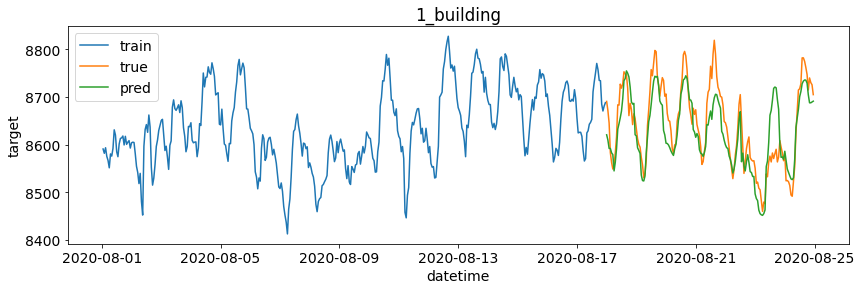

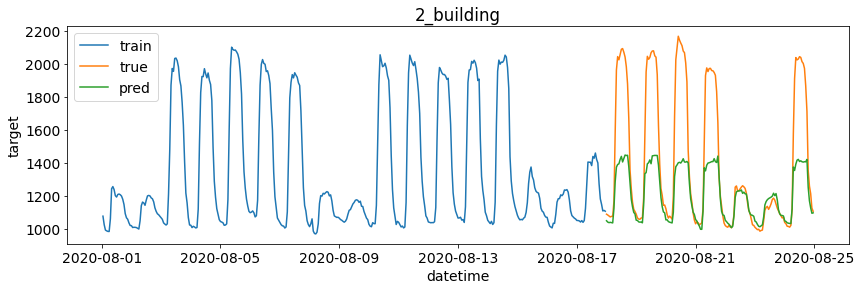

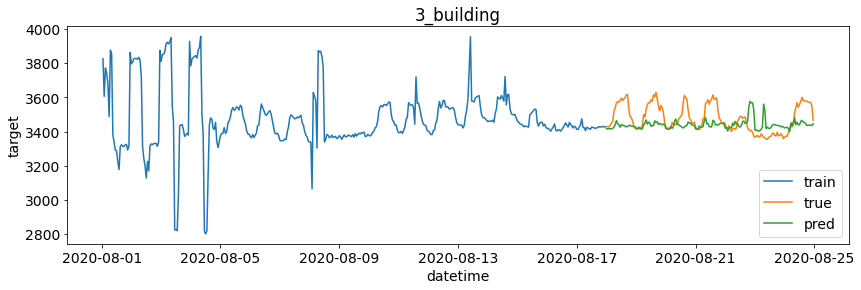

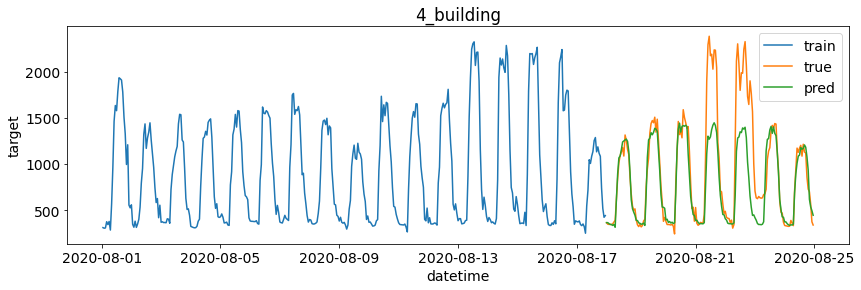

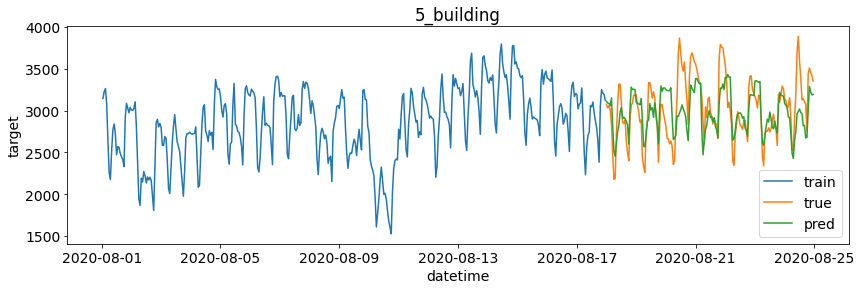

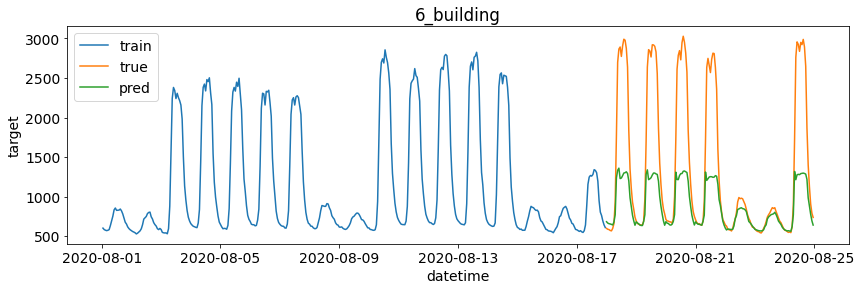

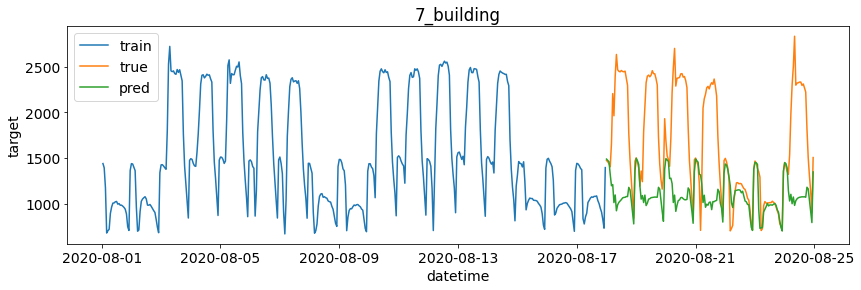

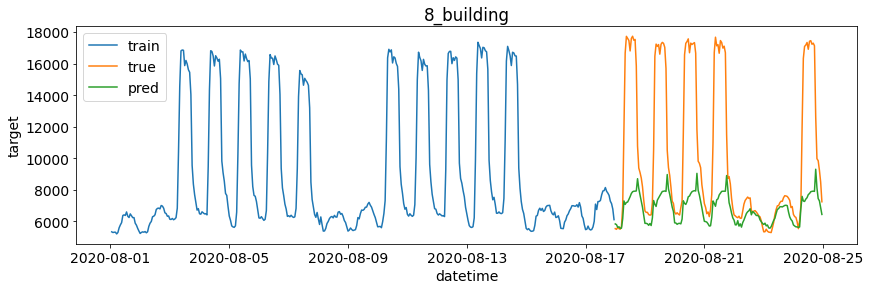

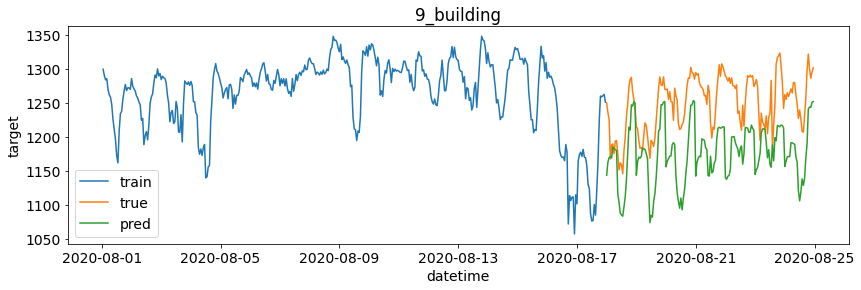

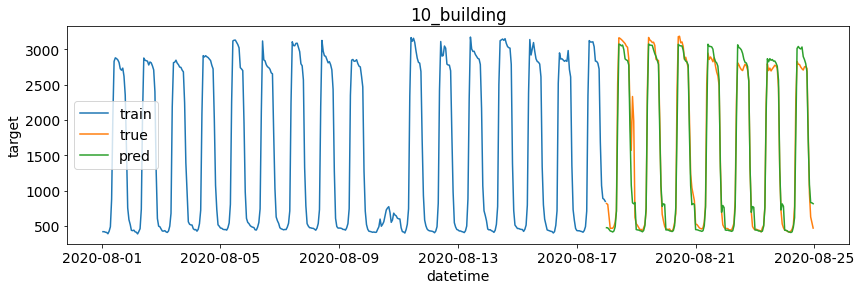

In [838]:
for i in range(1, 11):
    plt.figure(figsize=(14, 4))
    sns.lineplot(data=X.loc[(X.num == i) & (X.datetime > '2020-08-01')], x='datetime', y='target')
    sns.lineplot(data=predict_df.loc[predict_df.num == i], x='datetime', y='target')
    sns.lineplot(data=predict_df.loc[predict_df.num == i], x='datetime', y='preds')
    plt.legend(['train', 'true', 'pred'])
    plt.title('{}_building'.format(i))
    plt.show()

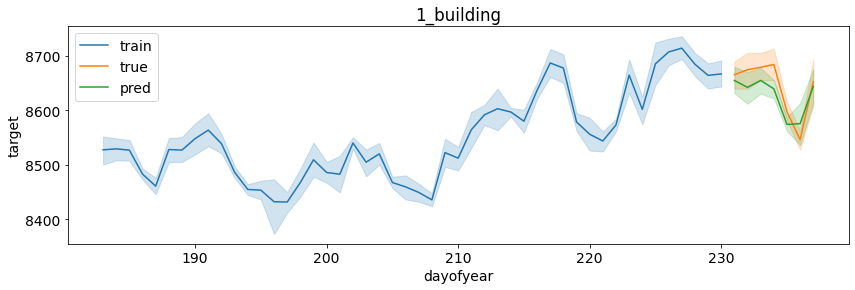

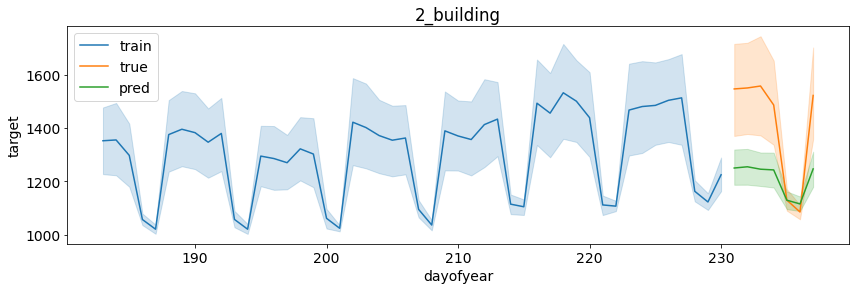

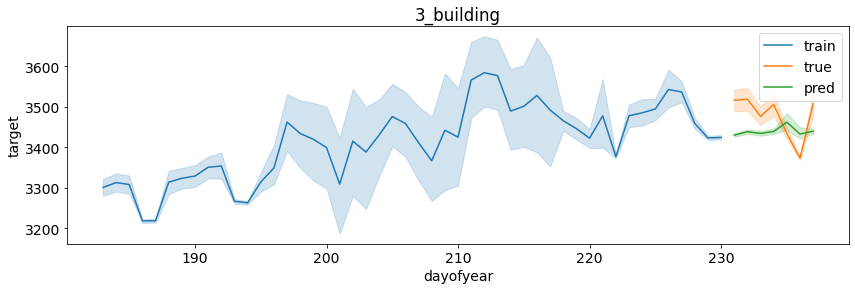

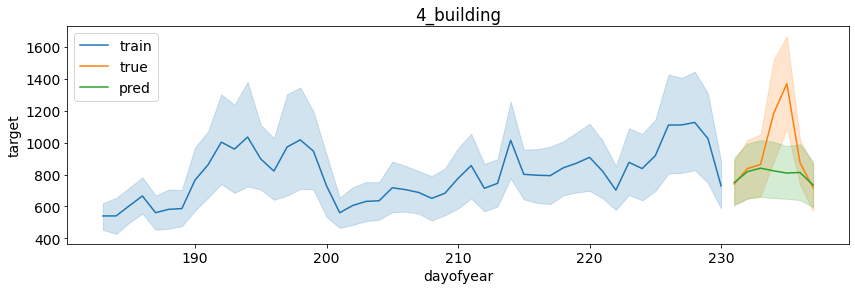

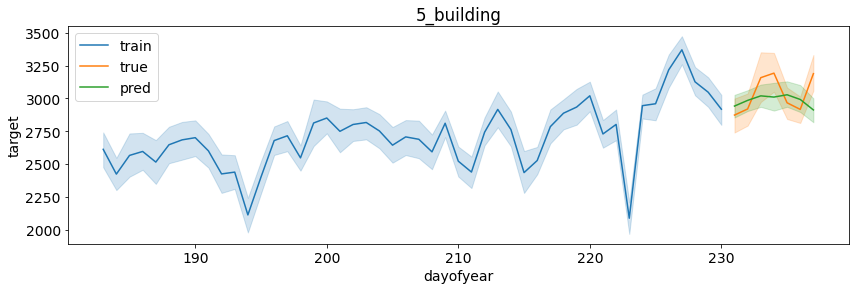

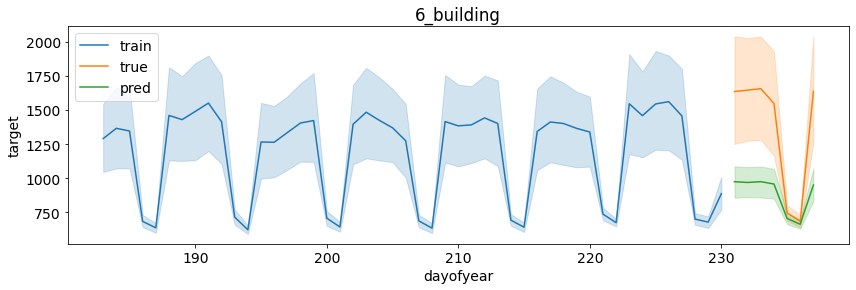

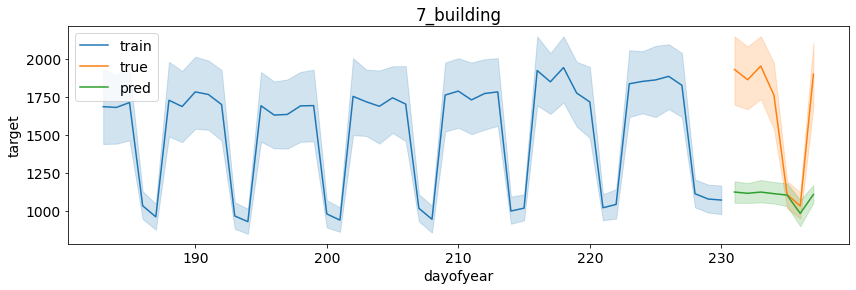

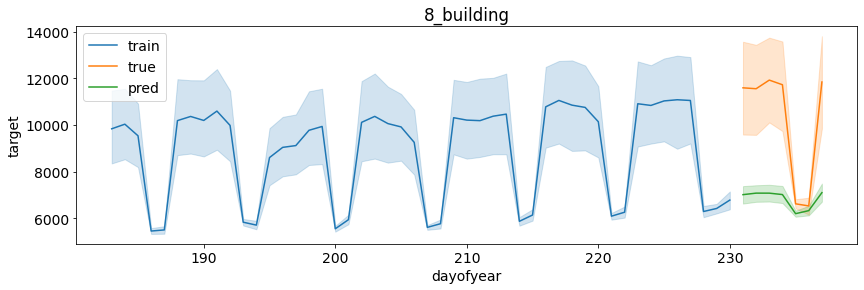

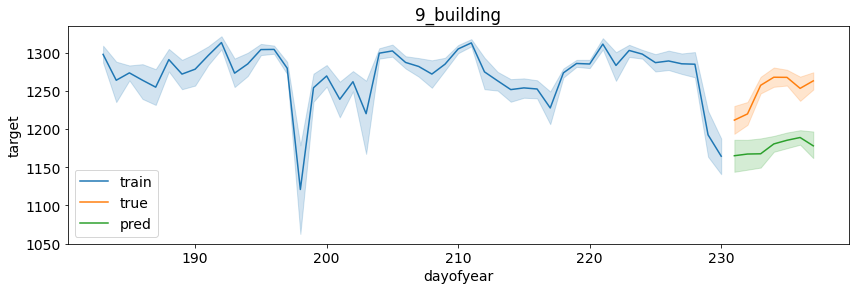

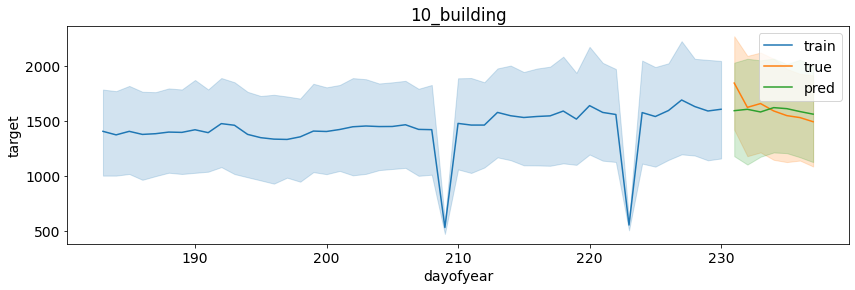

In [845]:
for i in range(1, 11):
    plt.figure(figsize=(14, 4))
    sns.lineplot(data=X.loc[(X.num == i) & (X.datetime > '2020-07-01')], x='dayofyear', y='target')
    sns.lineplot(data=predict_df.loc[predict_df.num == i], x='dayofyear', y='target')
    sns.lineplot(data=predict_df.loc[predict_df.num == i], x='dayofyear', y='preds')
    plt.legend(['train', 'true', 'pred'])
    plt.title('{}_building'.format(i))
    plt.show()

## 리니어 모델로 해보자

In [857]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

preds = []
fe = []
scores = []
for i in tqdm(range(1, 61)):
    lr = LinearRegression(normalize=True)
    lr.fit(globals()['x_train_{}'.format(i)], globals()['y_train_{}'.format(i)])
    pred = lr.predict(globals()['x_test_{}'.format(i)])
    preds.append(pred.tolist())
    fe.append(lr.coef_)
    scores.append(SMAPE(globals()['y_test_{}'.format(i)], pred))

100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 241.94it/s]


In [858]:
np.sum(scores)

550.8150189867082

In [859]:
predict_df = y[['num', 'target', 'dayofyear', 'datetime']]
predict_df['preds'] = sum(preds, [])

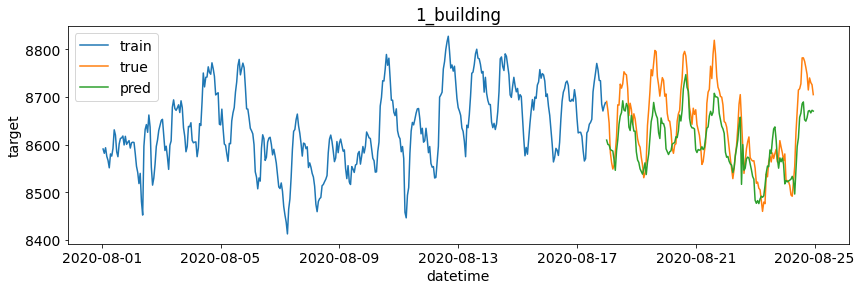

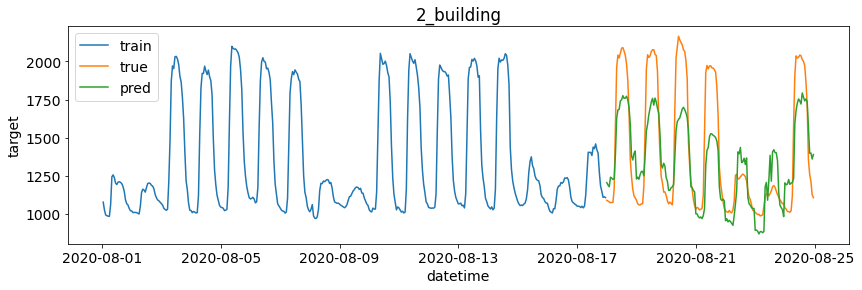

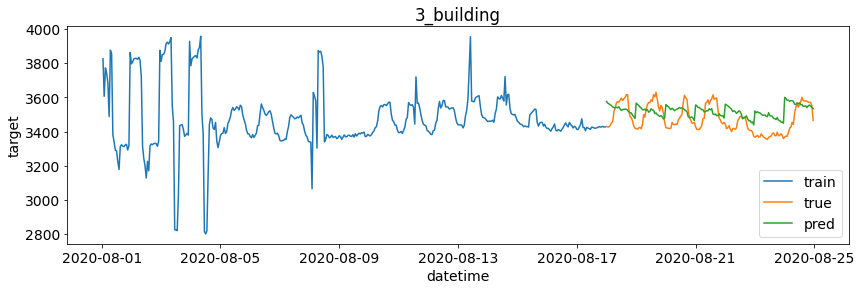

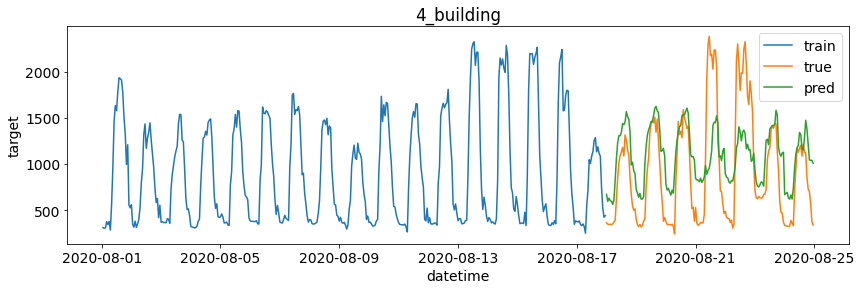

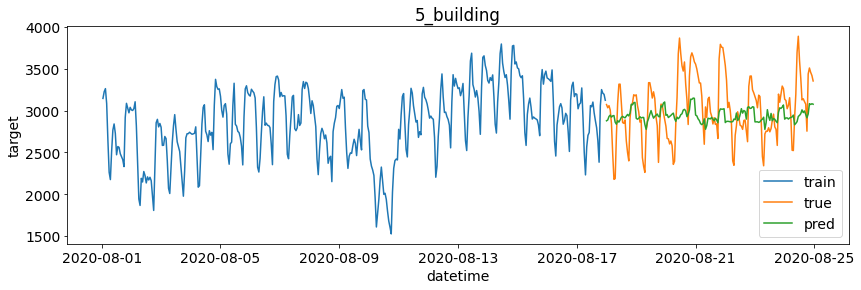

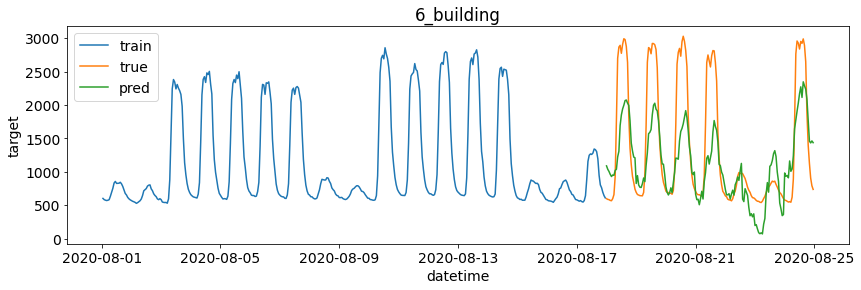

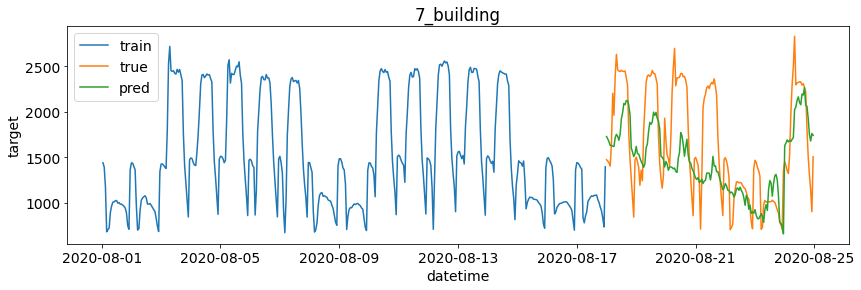

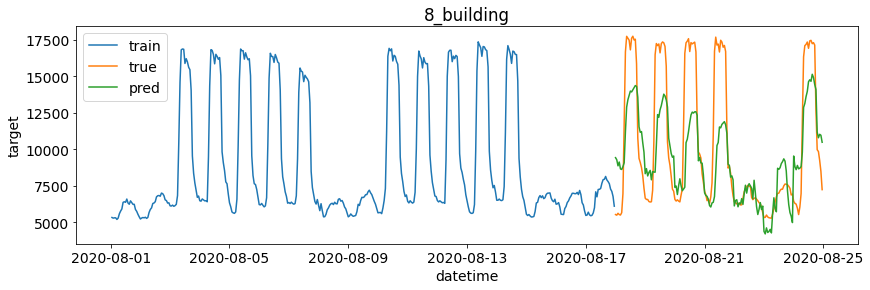

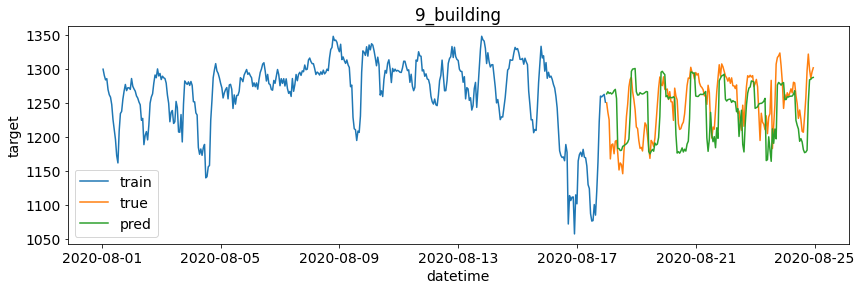

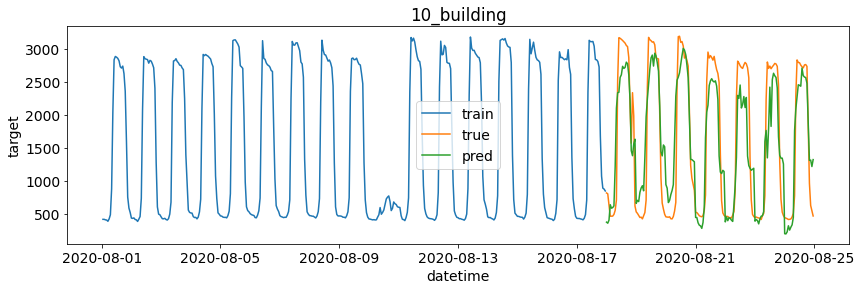

In [860]:
for i in range(1, 11):
    plt.figure(figsize=(14, 4))
    sns.lineplot(data=X.loc[(X.num == i) & (X.datetime > '2020-08-01')], x='datetime', y='target')
    sns.lineplot(data=predict_df.loc[predict_df.num == i], x='datetime', y='target')
    sns.lineplot(data=predict_df.loc[predict_df.num == i], x='datetime', y='preds')
    plt.legend(['train', 'true', 'pred'])
    plt.title('{}_building'.format(i))
    plt.show()

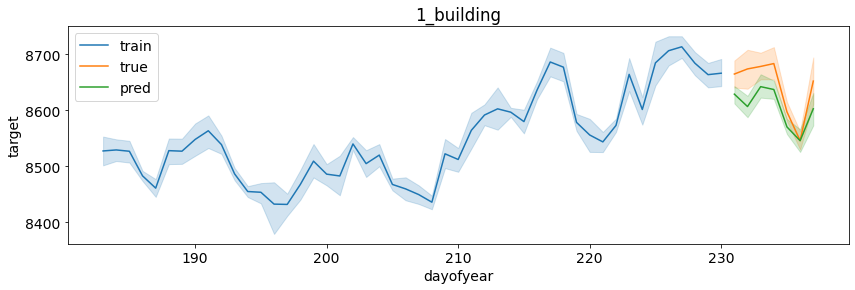

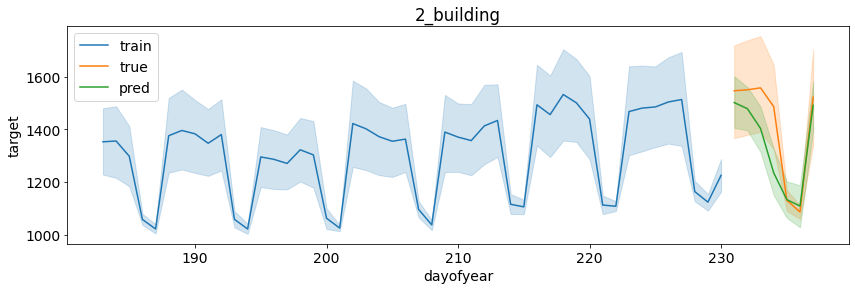

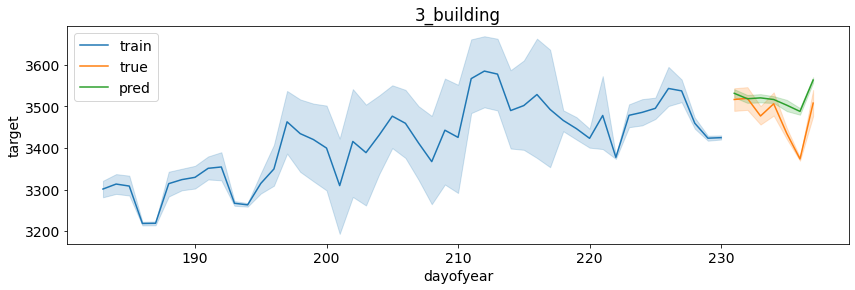

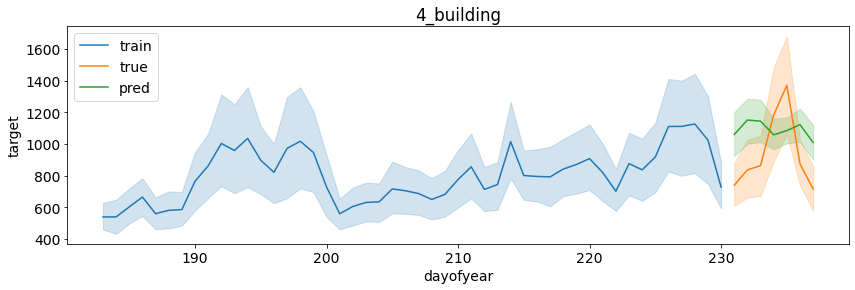

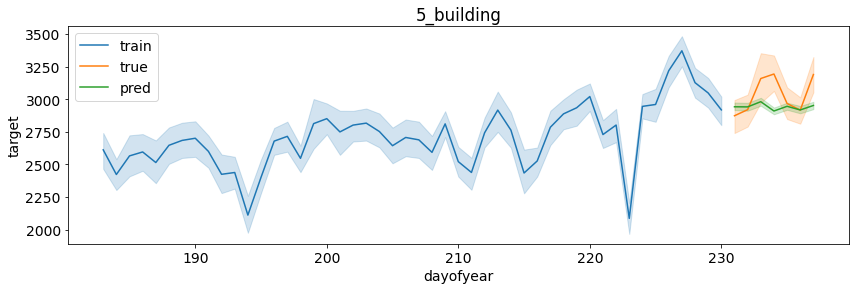

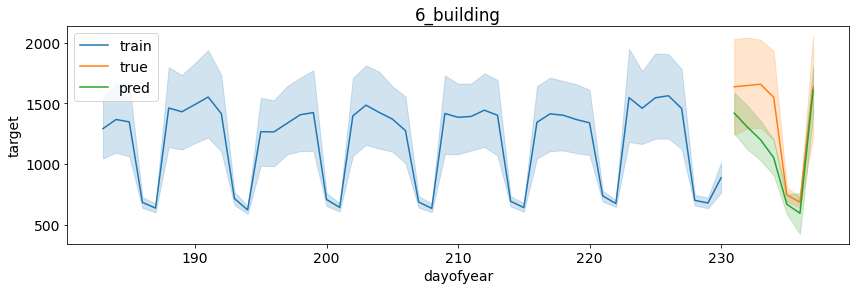

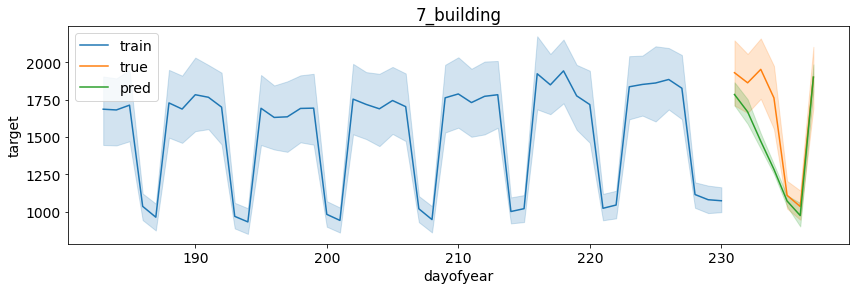

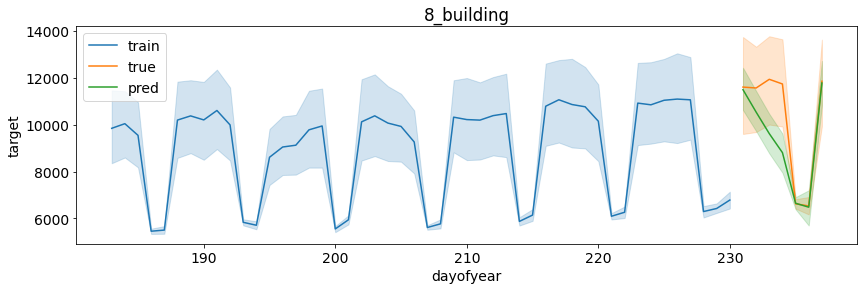

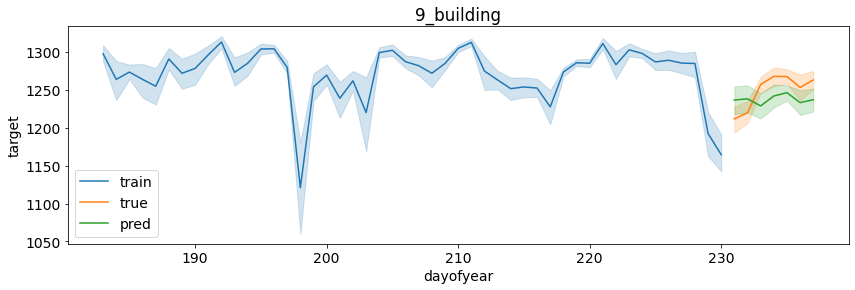

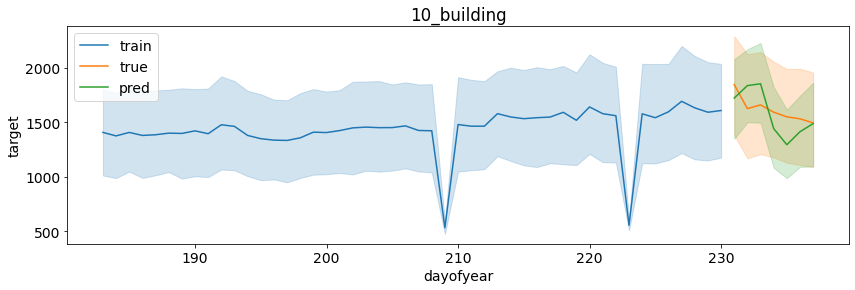

In [861]:
for i in range(1, 11):
    plt.figure(figsize=(14, 4))
    sns.lineplot(data=X.loc[(X.num == i) & (X.datetime > '2020-07-01')], x='dayofyear', y='target')
    sns.lineplot(data=predict_df.loc[predict_df.num == i], x='dayofyear', y='target')
    sns.lineplot(data=predict_df.loc[predict_df.num == i], x='dayofyear', y='preds')
    plt.legend(['train', 'true', 'pred'])
    plt.title('{}_building'.format(i))
    plt.show()

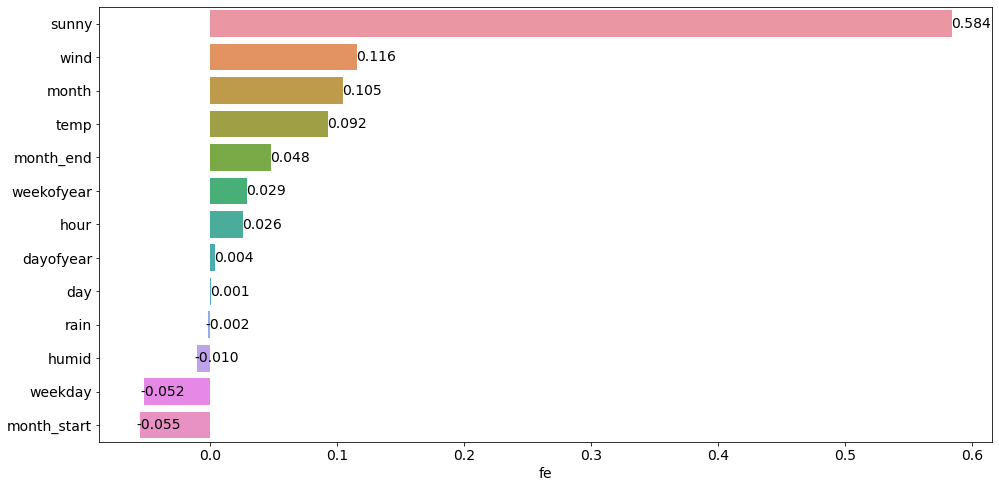

In [872]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fe, axis=0),
                      index=x_train_1.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(16, 8))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()